# Carga de librerías y del dataset

Importamos librerías, cargamos el dataframe, y hacemos las transformaciones pertinentes para poder tratar los datos como series temporales.

In [1]:
%autosave 0

Autosave disabled


In [2]:
# Importación de librerías para las fases iniciales del proyecto

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Cargamos el dataframe, convirtiendo la columna "Date" a formato pandas datetime, y fijándolo como índice

df=pd.read_csv('River_Arno.csv')

df['Date']=pd.to_datetime(df['Date'], format="%d/%m/%Y")

df=df.set_index('Date')

# 3. Preprocesado de datos y Análisis exploratorio (Primera Parte)

En primer lugar, vamos a explorar el dataset en su conjunto, en términos muy generales.

In [4]:
df.head(3)

,Rainfall_Le_Croci,Rainfall_Cavallina,Rainfall_S_Agata,Rainfall_Mangona,Rainfall_S_Piero,Rainfall_Vernio,Rainfall_Stia,Rainfall_Consuma,Rainfall_Incisa,Rainfall_Montevarchi,Rainfall_S_Savino,Rainfall_Laterina,Rainfall_Bibbiena,Rainfall_Camaldoli,Temperature_Firenze,Hydrometry_Nave_di_Rosano
Date,,,,,,,,,,,,,,,,
1998-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.82
1998-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.94
1998-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.11


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8217 entries, 1998-01-01 to 2020-06-30
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Rainfall_Le_Croci          6026 non-null   float64
 1   Rainfall_Cavallina         6026 non-null   float64
 2   Rainfall_S_Agata           6026 non-null   float64
 3   Rainfall_Mangona           6026 non-null   float64
 4   Rainfall_S_Piero           6026 non-null   float64
 5   Rainfall_Vernio            4283 non-null   float64
 6   Rainfall_Stia              1283 non-null   float64
 7   Rainfall_Consuma           1283 non-null   float64
 8   Rainfall_Incisa            4568 non-null   float64
 9   Rainfall_Montevarchi       1647 non-null   float64
 10  Rainfall_S_Savino          1283 non-null   float64
 11  Rainfall_Laterina          1283 non-null   float64
 12  Rainfall_Bibbiena          2378 non-null   float64
 13  Rainfall_Camaldoli         128

Como podemos ver, en este conjunto de datos se recogen observaciones en el espacio de tiempo transcurrido entre el 1998-01-01 (en adelante, seguiremos utilizando esta nomenclatura Año-Mes-Día) y el 2020-06-30.

Comprobamos que la frecuencia de las observaciones sea diaria, y que no tenemos ninguna fecha intermedia que no esté presente en el dataframe.

In [6]:
# No hay diferencias entre un índice diario declarado en el intervalo inicio-fin de las observaciones, y el índice del dataframe
pd.date_range(start='1998-01-01', end='2020-06-30', freq='D').difference(df.index)

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

A continuación, resumimos las diferentes variables de estudio en este problema:

- **VARIABLE OBJETIVO: Hydrometry_Nave_di_Rosano**. Nivel de caudal de agua que transporta el río Arno en un día concreto, expresado en metros, medido en la estación hidrométrica de Nave di Rosano.
    - Existen unos pocos valores nulos.
- **Variables Rainfall_**: Cantidad de precipitación acumulada en un día concreto, expresada en mm/m2, medida en pluviómetros situados en diferentes lugares.
    - Existen valores nulos, la cantidad de nulos no es la misma en todos los pluviómetros.
- **Variable Temperature_Firenze**: Temperatura media, expresada en ºC, medida en la ribereña ciudad de Florencia.
    - También existen valores nulos
    
En primer lugar, se estudiará en qué puntos en concreto se tienen estos valores nulos, y se decidirá qué hacer con ellos.

## 3.1 Tratamiento de nulos

En la siguiente celda, se construye una visualización en la que se podrá detectar los puntos en el tiempo en los que tenemos valores faltantes en cada una de las variables.

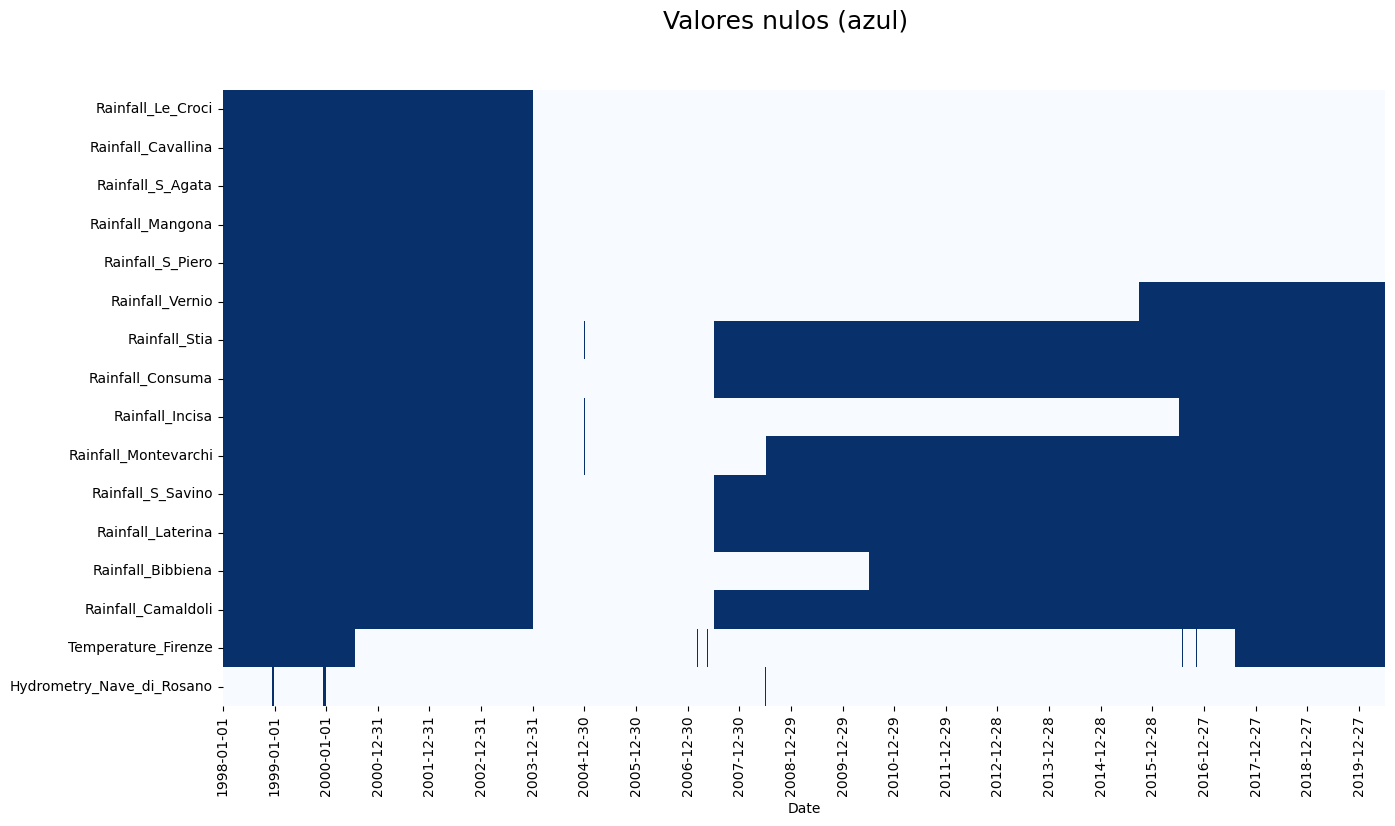

In [7]:
dfnulls = df.T.isna()

dfnulls.columns = dfnulls.columns.astype('str')

fig, ax = plt.subplots(figsize=(15,8))
sns.heatmap(dfnulls, cmap='Blues', cbar=False, xticklabels = 365, yticklabels=True)
fig.suptitle('Valores nulos (azul)', fontsize=18)

plt.show()

A continuación, se analizan los resultados obtenidos, y las decisiones que se tomarán a nivel de tratamiento de datos.

- Vemos que, desde el 1998-01-01 (inicio de las mediciones) hasta 2003-12-31, apenas tenemos datos de las variables de estudio.
    - **Se eliminarán los datos de este intervalo.**
- A partir de este intervalo, para la variable target, prácticamente no hay valores nulos
    - **Los casos aislados de nulos, se detectarán y corregirán**
- A partir de finales de 2017, no hay mediciones de temperatura. Antes de este intervalo, hay unos pocos nulos aislados
    - **Se tratará de recabar estos datos, y añadirlos al dataframe**
    - **Los casos aislados de nulos, se detectarán y corregirán**
- Para algunos de los pluviómetros (Vernio, Stia, Consuma, Incisa, Montevarchi, S_Saviro, Laterina, Bibbiena, Camaldoli), falta información en un intervalo de tiempo muy significativo.
    - **Eliminaremos los datos de estos pluviómetros de nuestro estudio.**

Ejecutamos las decisiones tomadas:

In [8]:
# Nos quedamos con el intervalo donde tenemos variables de estudio

df = df.loc['2004-01-01':]

In [9]:
# Eliminamos los datos de los pluviómetros en los que faltan muchas mediciones

df.drop(axis=1, columns=['Rainfall_Vernio',
       'Rainfall_Stia', 'Rainfall_Consuma', 'Rainfall_Incisa',
       'Rainfall_Montevarchi', 'Rainfall_S_Savino', 'Rainfall_Laterina',
       'Rainfall_Bibbiena', 'Rainfall_Camaldoli'], inplace=True)

**Completamos la serie temporal de la temperatura**

Se han localizado en la web los datos históricos de temperatura en la ciudad de Florencia, incluidos aquellos del intervalo que nos interesa (desde finales de 2017 hasta la fecha final de las observaciones recogidas en el dataset, 2020-06-30).

https://www.ilmeteo.net/meteo_Firenze-Europa-Italia-Firenze--sactual-29832.html

Nótese que las temperaturas están medidas en el aeropuerto de Florencia, mientras que desconocemos en qué estación de medición se tomaron las medidas que tenemos en nuestro dataframe. Tendremos que cercionarnos de que los valores son equiparables.

Por ello, se copian a un csv no sólo las temperaturas medias en Florencia para el intervalo de fechas en el que no tenemos datos (2017-08-04 en adelante), sino que se cargarán datos desde el inicio de 2015, para estudiar la correspondencia entre las medidas que ofrece esta web, y las que tenemos en nuestro dataframe en el intervalo de solape (2015-01-01 a 2017-08-03).

In [10]:
# Cargamos el .csv y procesamos la fecha como índice
datos_extra_temperatura = pd.read_csv('temperaturas.csv', names=['Date', 'Temperature_Firenze'])
datos_extra_temperatura['Date']=pd.to_datetime(datos_extra_temperatura['Date'], format="%d/%m/%Y")
datos_extra_temperatura=datos_extra_temperatura.set_index('Date')

# Inspeccionamos
datos_extra_temperatura.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2008 entries, 2015-01-01 to 2020-06-30
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Temperature_Firenze  2008 non-null   int64
dtypes: int64(1)
memory usage: 31.4 KB


In [11]:
datos_extra_temperatura.head(3)

,Temperature_Firenze
Date,
2015-01-01,5
2015-01-02,5
2015-01-03,6


Análisis de la correspondencia entre ambas mediciones

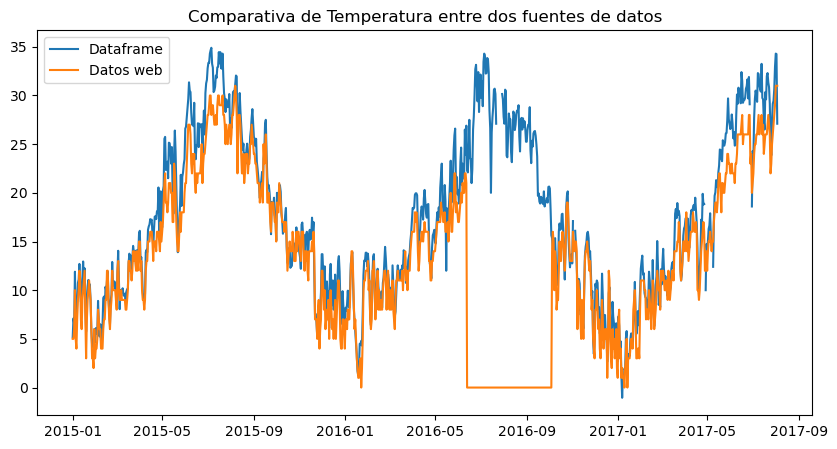

In [12]:
# Visualizamos los valores de cada una de las estaciones de medida, en el intervalo que tenemos datos de ambas

plt.figure(figsize=(10,5))
axes = plt.plot(df.loc['2015-01-01':'2017-08-03', ['Temperature_Firenze']])
axes[0].set_label('Dataframe')
axes = plt.plot(datos_extra_temperatura.loc['2015-01-01':'2017-08-03', ['Temperature_Firenze']])
axes[0].set_label('Datos web')
plt.legend()
plt.title('Comparativa de Temperatura entre dos fuentes de datos')

plt.show()

Más allá de los valores anómalos a mediados del año 2016 para los datos web (que no nos afectarían puesto que no pretendemos utilizar este intervalo de medidas para nuestro estudio), se observa que la temperatura medida en la estación que tenemos en el Dataframe, es ligeramente mayor que la que se tiene al medirla en el aeropuerto (Datos web).

Cuantitativamente:

In [13]:
diff_temperaturas = pd.DataFrame()
diff_temperaturas['Dataframe'] = df.loc['2015-01-01':'2017-08-03', ['Temperature_Firenze']].copy()
diff_temperaturas['Datos_web'] = datos_extra_temperatura.loc['2015-01-01':'2017-08-03', ['Temperature_Firenze']].copy()
diff_temperaturas['Diferencia'] = diff_temperaturas['Dataframe'] - diff_temperaturas['Datos_web']

diff_temperaturas.head(3)

,Dataframe,Datos_web,Diferencia
Date,,,
2015-01-01,5.15,5,0.15
2015-01-02,7.10,5,2.10
2015-01-03,6.55,6,0.55


In [14]:
# Eliminamos del cálculo los valores anómalos
diff_temperaturas = diff_temperaturas.loc[diff_temperaturas.Datos_web != 0]

print(f'La diferencia media de temperatura entre las dos estaciones es {diff_temperaturas.Diferencia.mean():.1f} ºC')

La diferencia media de temperatura entre las dos estaciones es 1.7 ºC


La diferencia es apreciable, pero quizá sean lo suficientemente parecidas para no desvirtuar el estudio que pretendemos realizar. 

A partir del 2017-08-04, cambiaremos la fuente de datos para la medición de temperatura, pero tenemos la cantidad de datos suficientes desde ese punto hasta el final del dataset para confiar en que no afecte en demasía a los modelos que entrenaremos con estos datos.

Así, **decidimos incorporar las medidas de temperatura del aeropuerto de Florencia para el intervalo en el que no teníamos datos (2017-08-04 a 2020-06-30).**

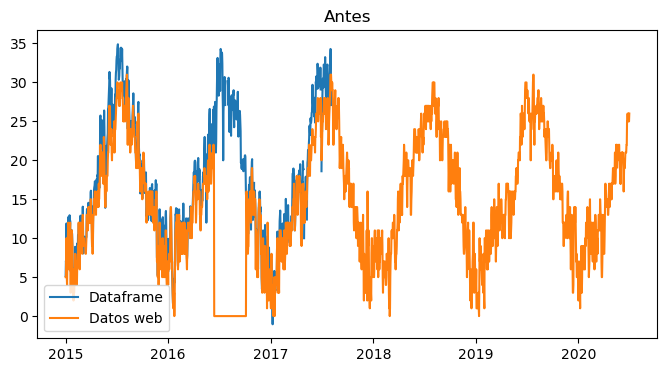

In [15]:
# Visualización de ambas series antes del reemplazo
plt.figure(figsize=(8,4))
axes = plt.plot(df.loc['2015-01-01':'2020-06-30', ['Temperature_Firenze']])
axes[0].set_label('Dataframe')
axes = plt.plot(datos_extra_temperatura.loc['2015-01-01':'2020-06-30', ['Temperature_Firenze']])
axes[0].set_label('Datos web')
plt.legend()
plt.title('Antes')

plt.show()

In [16]:
# Reemplazo
df.loc['2017-08-04':,'Temperature_Firenze'] = datos_extra_temperatura.loc['2017-08-04':, 'Temperature_Firenze'].copy()

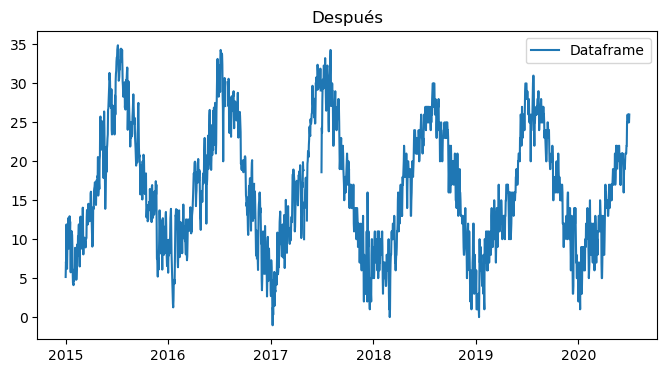

In [17]:
# Visualización de la serie después del reemplazo
plt.figure(figsize=(8,4))
axes = plt.plot(df.loc['2015-01-01':'2020-06-30', ['Temperature_Firenze']])
axes[0].set_label('Dataframe')
plt.legend()
plt.title('Después')

plt.show()

In [18]:
df.isnull().sum()

Rainfall_Le_Croci             0
Rainfall_Cavallina            0
Rainfall_S_Agata              0
Rainfall_Mangona              0
Rainfall_S_Piero              0
Temperature_Firenze          20
Hydrometry_Nave_di_Rosano     3
dtype: int64

Aún quedan unos pocos casos aislados de nulos, se tratarán en la próxima sección, cuando hagamos el análisis exploratorio de cada variable.

Vista del principio y final de nuestro dataframe, justo antes de comenzar a explorar las variables:

In [19]:
df

,Rainfall_Le_Croci,Rainfall_Cavallina,Rainfall_S_Agata,Rainfall_Mangona,Rainfall_S_Piero,Temperature_Firenze,Hydrometry_Nave_di_Rosano
Date,,,,,,,
2004-01-01,0.0,0.0,0.4,0.0,0.0,8.65,1.84
2004-01-02,0.0,0.0,0.0,0.0,0.0,7.10,1.93
2004-01-03,0.0,0.0,0.0,0.0,0.0,5.50,1.61
2004-01-04,0.0,0.0,0.0,0.0,0.0,3.55,1.35
2004-01-05,0.0,0.0,0.0,0.0,0.2,2.70,1.44
...,...,...,...,...,...,...,...
2020-06-26,0.0,0.0,0.0,0.0,0.0,25.00,1.34
2020-06-27,0.0,0.0,0.0,0.0,0.0,26.00,1.21
2020-06-28,0.0,0.0,0.0,0.0,0.0,26.00,1.30


## 3.2 Análisis de la target: Hidrometría

Empezamos visualizando toda la serie temporal para nuestra variable target.

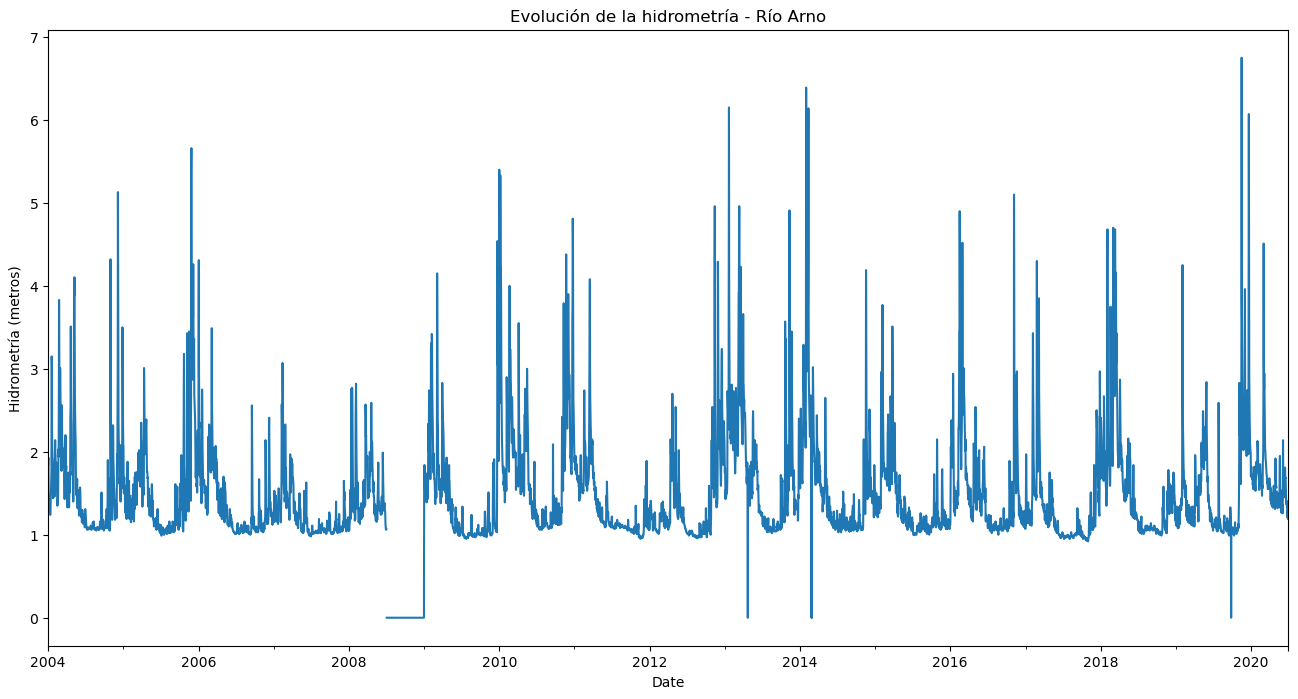

In [20]:
df.Hydrometry_Nave_di_Rosano.plot(figsize=(16,8))
plt.ylabel('Hidrometría (metros)')
plt.title('Evolución de la hidrometría - Río Arno')
plt.show()

En primer lugar, como ya se había comentado, tratamos los valores atípicos/nulos que aún estaban presentes.

In [21]:
# Imputamos los valores atípicos (= 0) usando la hidrometría media de su mes correspondiente
index_month = df.index.month
df_hydrom_by_month = df.Hydrometry_Nave_di_Rosano.groupby(index_month).mean().round(2).to_dict()

for month in range (1,13):
    df.loc[(df.Hydrometry_Nave_di_Rosano == 0) & (df.index.month == month),'Hydrometry_Nave_di_Rosano']  \
    = df_hydrom_by_month.get(month)

In [22]:
# Los 3 valores nulos que aún quedaban, los imputamos propagando hacia adelante el valor de la última observación válida 
# (método conocido como 'forward fill')

df.Hydrometry_Nave_di_Rosano.fillna(method='ffill', inplace=True)

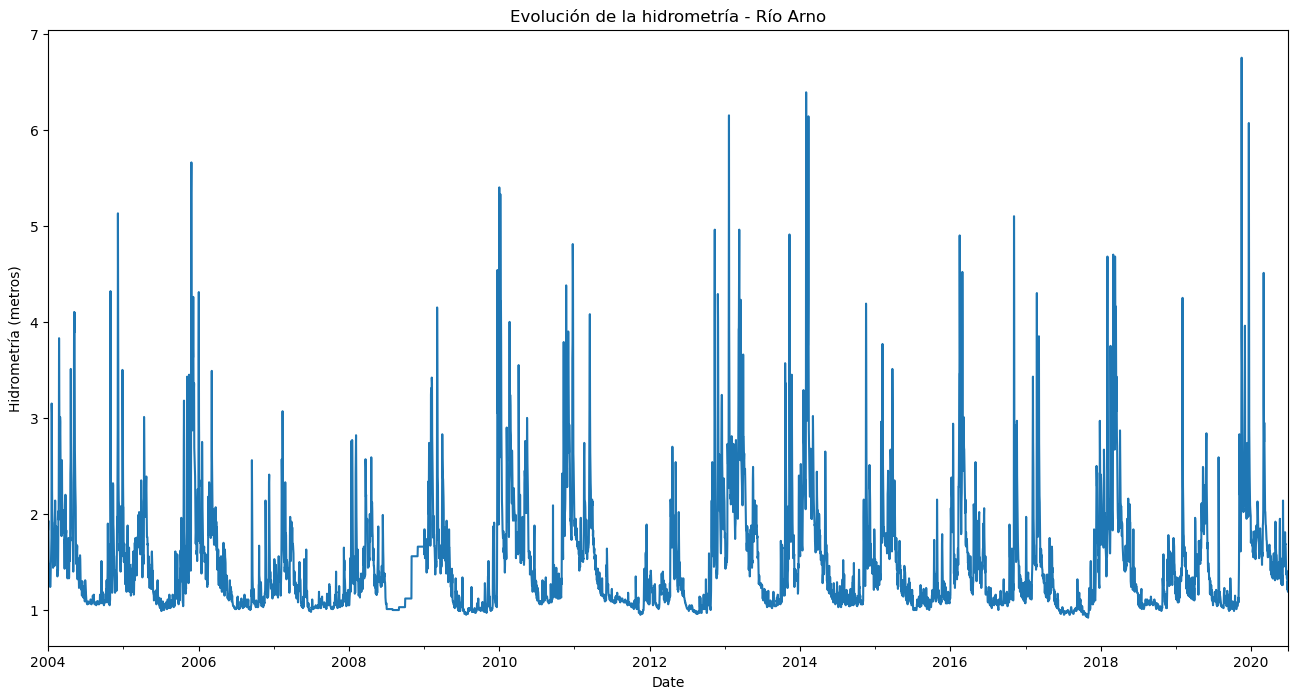

In [23]:
df.Hydrometry_Nave_di_Rosano.plot(figsize=(16,8))
plt.ylabel('Hidrometría (metros)')
plt.title('Evolución de la hidrometría - Río Arno')
plt.show()

Ya a primera vista, se observa que los niveles del río siguen un patrón cíclico anual, con cierta variabilidad y ciertos matices cada año.

Además de la visualización de la serie temporal completa, vamos a incluir otras dos visualizaciones que facilitarán el análisis:

   - Visualización de la serie temporal para un año en concreto. En la visualización anterior, al tener demasiados datos, las líneas se solapan entre ellas, observando un sólo año se observará mejor cómo evoluciona la serie

   - Visualización de la serie temporal con datos de granularidad mes, en vez de día. Nos interesa suavizar esas subidas y bajadas bruscas que se intuyen en la visualización anterior, para poder captar mejor tendencias generales

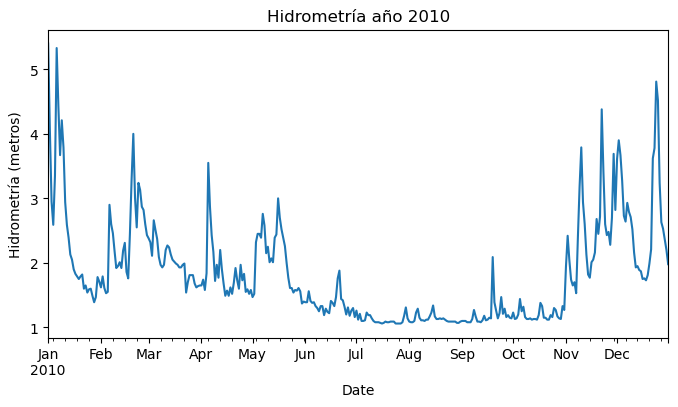

In [24]:
df.Hydrometry_Nave_di_Rosano.loc['2010'].plot(figsize=(8,4))
plt.ylabel('Hidrometría (metros)')
plt.title('Hidrometría año 2010')
plt.show()

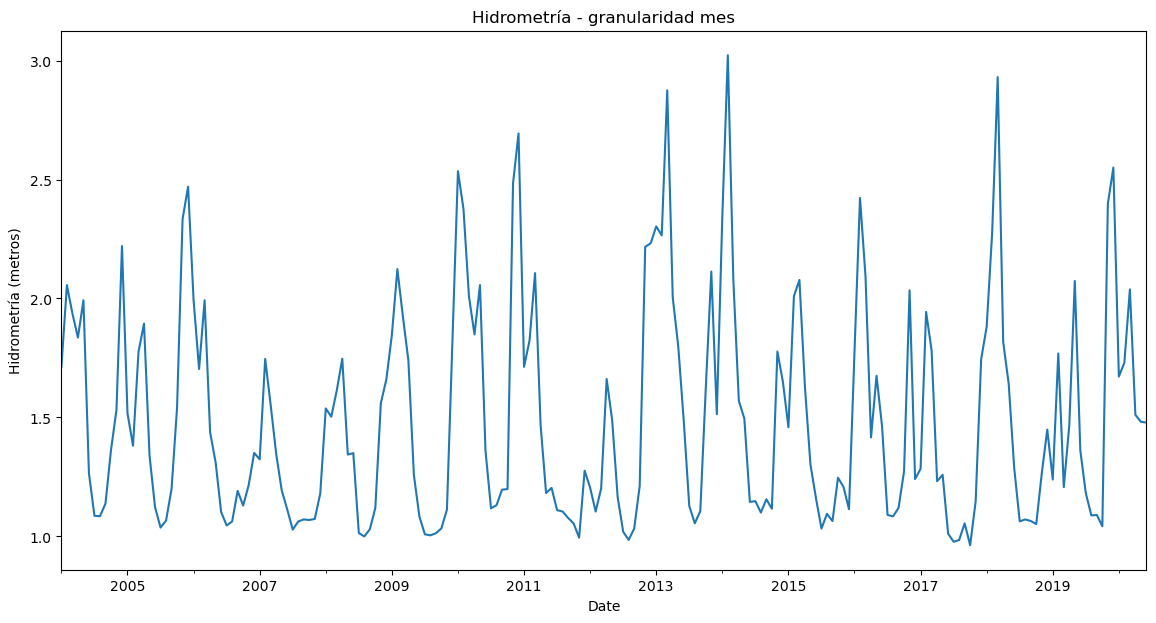

In [25]:
ax = df.Hydrometry_Nave_di_Rosano.resample('M').agg(['mean']).plot(figsize=(14,7))
ax.get_legend().remove()
plt.ylabel('Hidrometría (metros)')
plt.title('Hidrometría - granularidad mes')
plt.show()

Como ya se había adelantado, los datos siguen un patrón cíclico, pero con matices.

- Tendencia general: En los meses de verano se dan los niveles más bajos, en invierno los niveles más altos, y en primavera y otoño se ve una transición.

- Matiz: En la visualización para un año concreto, se aprecia que los niveles del río tienen muchos "picos": se dan subidas y bajadas bruscas del nivel.

- Matiz: En la visualización para granularidad mes, se ve que hay variaciones de año a año
    - En invierno, hay años que el río lleva más caudal, y años que lleva bastante menos (la altura de las "montañas" que describe la línea, varían cada año)
    - Cada año, son meses diferentes los que tienen los caudales más altos (la forma de las "montañas" que describe la línea, son totalmente diferentes de año en año)
    
A la hora de analizar una serie temporal, estos matices han de ser tenidos muy en cuenta. Parece que se trata de una serie que sí que tiene un comportamiento _cíclico_ (se van repitiendo ciertos patrones en el tiempo), pero no tiene _estacionalidad_ (los patrones no ocurren en intervalos de tiempo regulares, y no siempre se dan de la misma forma).

**En estas fases iniciales del análisis, vamos a centrarnos en explorar las tendencias generales**. Nos olvidamos por ahora de esos matices a la tendencia general, en secciones posteriores ahondaremos sobre ellos.
    
Visualizamos los valores medios de la hidrometría para cada año y para cada mes, teniendo en cuenta todos los datos de la serie temporal:

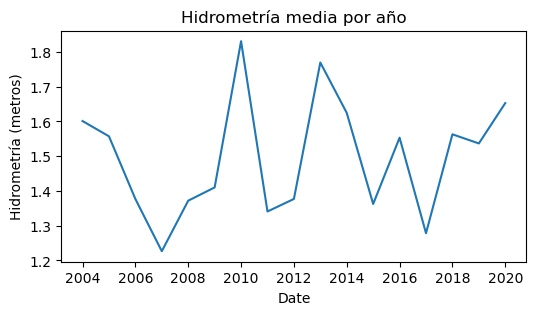

In [26]:
hydrometry_yearly = df.Hydrometry_Nave_di_Rosano.resample('Y').agg(['mean'])
index_yearly= hydrometry_yearly.index.year
hydrometry_yearly = hydrometry_yearly.groupby(index_yearly).mean()

ax = hydrometry_yearly.plot(figsize=(6,3))
ax.get_legend().remove()
plt.ylabel('Hidrometría (metros)')
plt.title('Hidrometría media por año')

plt.show()

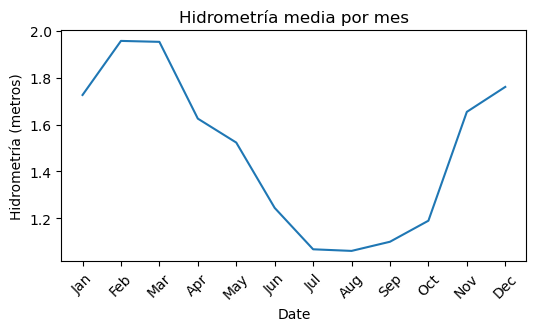

In [27]:
lista_de_meses = ['Jan','Feb', 'Mar', 'Apr', 'May', 'Jun', 
                  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

hydrometry_monthly = df.Hydrometry_Nave_di_Rosano.resample('M').agg(['mean'])
index_month = hydrometry_monthly.index.month

hydrometry_monthly = hydrometry_monthly.groupby(index_month).mean()

ax = hydrometry_monthly.plot(figsize=(6,3))
ax.get_legend().remove()
plt.ylabel('Hidrometría (metros)')
plt.title('Hidrometría media por mes')
ax.set_xticks(range(1,len(hydrometry_monthly)+1))
ax.set_xticklabels(lista_de_meses, rotation=45)

plt.show()

**CONCLUSIONES**

- Los niveles medios del río, medidos de año en año, experimentan cierta variabilidad, oscilando entre 1.2 metros (año 2005) y 1.8 metros (año 2010), aproximadamente
- A su vez, dentro de cada año hay variabilidad dependiendo del mes del año, con una diferencia de casi 1 metro entre los valores medios de los meses con más caudal de río (Febrero y Marzo) y los meses con menos caudal (Julio y Agosto)

## 3.3 Análisis de las precipitaciones (Rainfalls)

Visualizamos las series temporales de los diferentes puntos de medición de precipitación (variables "Rainfall_", pluviómetros).
En este caso, para facilitar la interpretación de las mismas, se muestran las precipitaciones medias durante cada mes de la serie temporal.

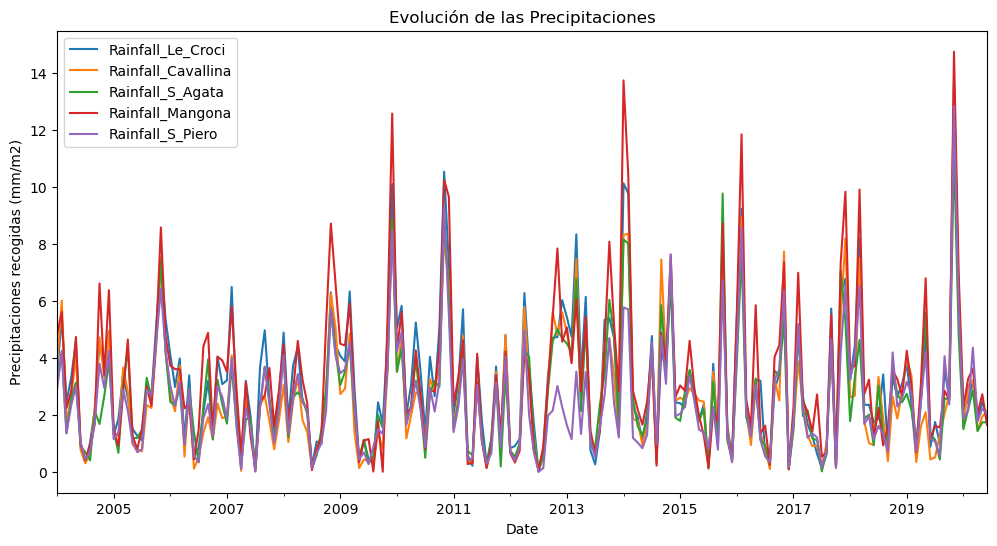

In [28]:
df.resample('M').agg(Rainfall_Le_Croci=('Rainfall_Le_Croci', 'mean'), Rainfall_Cavallina=('Rainfall_Cavallina', 'mean'),
                    Rainfall_S_Agata=('Rainfall_S_Agata', 'mean'), Rainfall_Mangona=('Rainfall_Mangona', 'mean'),
                    Rainfall_S_Piero=('Rainfall_S_Piero', 'mean')) \
                .plot(figsize=(12,6))
plt.ylabel('Precipitaciones recogidas (mm/m2)')
plt.title('Evolución de las Precipitaciones')
plt.show()

Las líneas que representan los valores para cada uno de los pluviómetros, parece que se solapan bastante.

Se va a explorar de forma más cuantitativa, a través de los coeficientes de correlación.

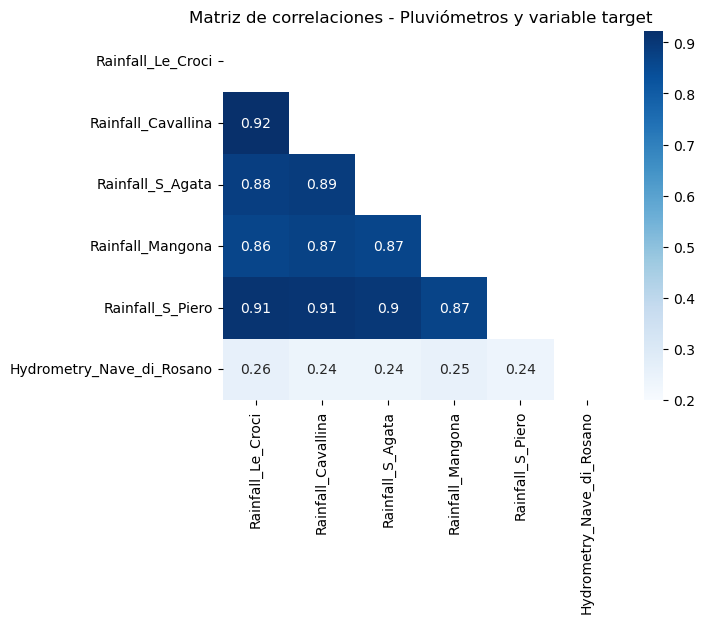

In [29]:
# Matriz de correlaciones

corr_rainfalls = df[['Rainfall_Le_Croci', 'Rainfall_Cavallina', 'Rainfall_S_Agata', 
                     'Rainfall_Mangona', 'Rainfall_S_Piero', 'Hydrometry_Nave_di_Rosano']].corr()

sns.heatmap(corr_rainfalls, annot=True, cmap='Blues', vmin=0.2, mask=np.triu(corr_rainfalls))
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Matriz de correlaciones - Pluviómetros y variable target')
plt.show()

Vemos que la correlación entre todos y cada uno de los pluviómetros es muy alta. También vemos que la correlación de cada pluviómetro con la target es muy similar. Para simplificar el análisis, se decide sustituir las variables que representan a cada pluviómetro, por una variable "Mean Rainfall" que represente la media de los valores recogidos diariamente en cada pluviómetro.

In [30]:
df['Mean_Rainfall'] = (df['Rainfall_Le_Croci'] + df['Rainfall_Cavallina'] + df['Rainfall_S_Agata']
                      + df['Rainfall_Mangona'] + df['Rainfall_S_Piero']) / 5
df.drop(['Rainfall_Le_Croci', 'Rainfall_Cavallina', 'Rainfall_S_Agata', 'Rainfall_Mangona', 'Rainfall_S_Piero'], 
        axis=1, inplace=True)

Intuitivamente, cabe esperar que las lluvias tengan una gran influencia en los niveles del río. Vamos a realizar algunas visualizaciones para testear esta hipótesis.

Se repiten las visualizaciones que habíamos mostrado al analizar la hidrometría: precipitación media por año, y precipitación media por mes. Normalizamos los datos y los solapamos con las visualizaciones análogas de hidrometría.

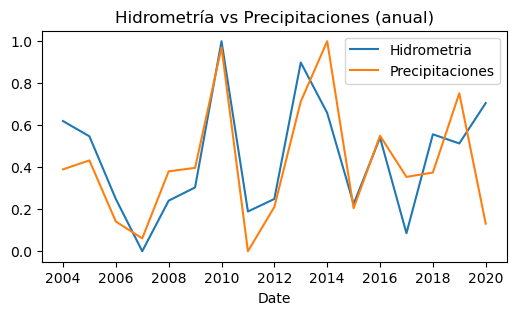

In [31]:
hydrom_vs_rainfall_yearly = df[['Hydrometry_Nave_di_Rosano', 'Mean_Rainfall']].resample('Y') \
                            .agg(Hidrometria=('Hydrometry_Nave_di_Rosano', 'mean'), Precipitaciones=('Mean_Rainfall', 'mean'))

# Una normalización min-max parece buena opción, ya que al realizar previamente el agregado nos evitamos
# valores demasiado extremos
hydrom_vs_rainfall_yearly = (hydrom_vs_rainfall_yearly - hydrom_vs_rainfall_yearly.min()) / \
                            (hydrom_vs_rainfall_yearly.max() - hydrom_vs_rainfall_yearly.min())

index_yearly= hydrom_vs_rainfall_yearly.index.year
hydrom_vs_rainfall_yearly = hydrom_vs_rainfall_yearly.groupby(index_yearly).mean()

hydrom_vs_rainfall_yearly.plot(figsize=(6,3))
plt.title('Hidrometría vs Precipitaciones (anual)')

plt.show()

En esta visualización, se observa cómo hay una correlación evidente entre los niveles medios anuales del río, y las precipitaciones recogidas. Eso sí, llama la atención cómo, para los últimos años de nuestra serie temporal (a partir de 2017), parece como si se perdiese esa correlación tan estrecha que hay en los años previos.

In [32]:
print(f'Coeficiente de correlación Hidrometría-Precipitación de 2004 a 2016:  \
      {hydrom_vs_rainfall_yearly.loc[:"2016"].corr().values[0,1]:.3f}')

print(f'Coeficiente de correlación Hidrometría-Precipitación de 2017 a 2020:  \
      {hydrom_vs_rainfall_yearly.loc["2017":].corr().values[0,1]:.3f}')

Coeficiente de correlación Hidrometría-Precipitación de 2004 a 2016:        0.873
Coeficiente de correlación Hidrometría-Precipitación de 2017 a 2020:        -0.158


Estamos extrayendo información a partir de datos agrupados por año, vamos a bajar a la granularidad de mes para observar este comportamiento anómalo.

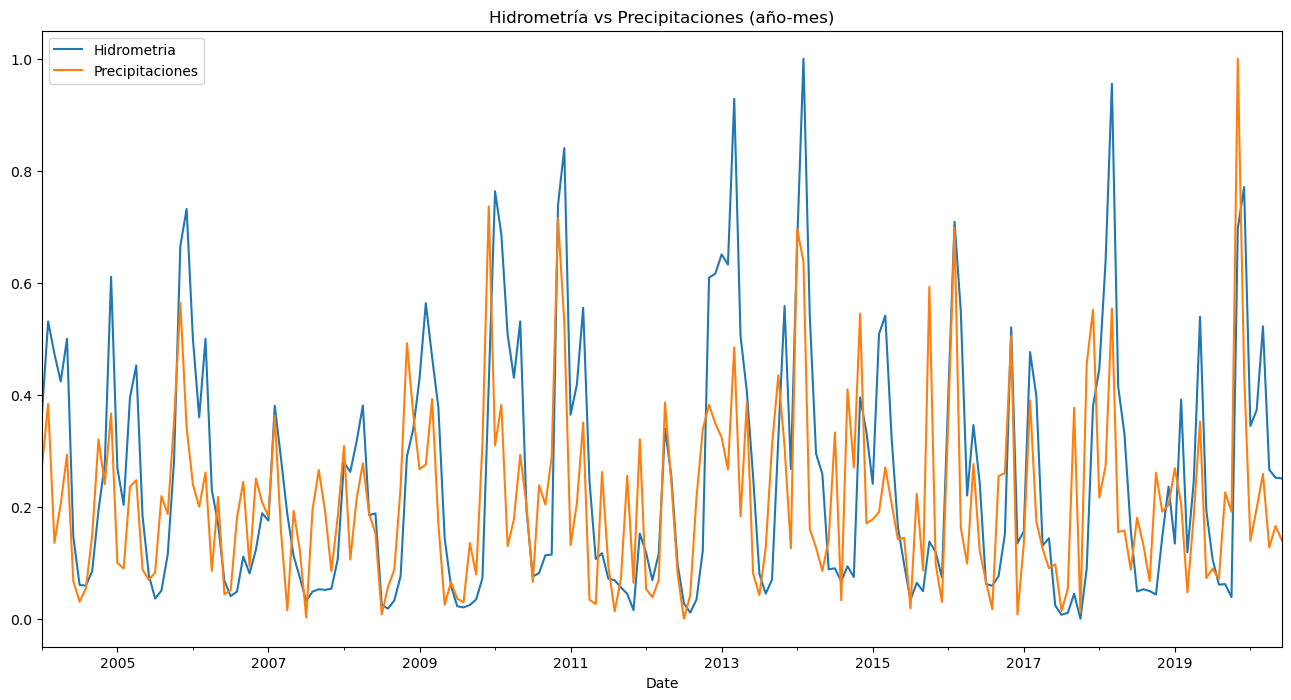

In [33]:
hydrom_vs_rainfall_yearmonth = df[['Hydrometry_Nave_di_Rosano', 'Mean_Rainfall']].resample('M') \
                            .agg(Hidrometria=('Hydrometry_Nave_di_Rosano', 'mean'), Precipitaciones=('Mean_Rainfall', 'mean'))

# Una normalización min-max parece buena opción, ya que al realizar previamente el agregado nos evitamos
# valores demasiado extremos
hydrom_vs_rainfall_yearmonth = (hydrom_vs_rainfall_yearmonth - hydrom_vs_rainfall_yearmonth.min()) / \
                            (hydrom_vs_rainfall_yearmonth.max() - hydrom_vs_rainfall_yearmonth.min())

hydrom_vs_rainfall_yearmonth.plot(figsize=(16,8))
plt.title('Hidrometría vs Precipitaciones (año-mes)')

plt.show()

En esta granularidad, no parece que haya una pérdida grande de correlación a partir de 2017.

Si computamos los coeficientes de correlación (bajando a la granularidad de día):

In [34]:
print(f'Coeficiente de correlación Hidrometría-Precipitación de 2004 a 2016:  \
      {df.loc[:"2016",["Hydrometry_Nave_di_Rosano", "Mean_Rainfall"]].corr().values[0,1]:.3f}')

print(f'Coeficiente de correlación Hidrometría-Precipitación de 2017 a 2020:  \
      {df.loc["2017":,["Hydrometry_Nave_di_Rosano", "Mean_Rainfall"]].corr().values[0,1]:.3f}')

Coeficiente de correlación Hidrometría-Precipitación de 2004 a 2016:        0.290
Coeficiente de correlación Hidrometría-Precipitación de 2017 a 2020:        0.147


Sigue habiendo diferencia, pero mucho menos acusada que para el cálculo de la granularidad año. Además, hay que recordar que para el año 2020 no tenemos la serie completa, los datos terminan el 2020-06-30, y puede ser que en la primera mitad del año la relación entre ambas variables sea diferente a la relación que se tiene computando el año entero.

Haría falta una análisis más profundo para determinar si se trata de una anomalía introducida a la hora de procesar los datos (granularidad año, normalización min-max), o se trata de un patrón que genuinamente está en los datos. Por ahora, anotaremos esta anomalía y la tendremos en mente si surgen problemas en la fase de modelado.

Prosiguiendo con el análisis, comparamos la precipitación media por mes, frente a la hidrometría media por mes.

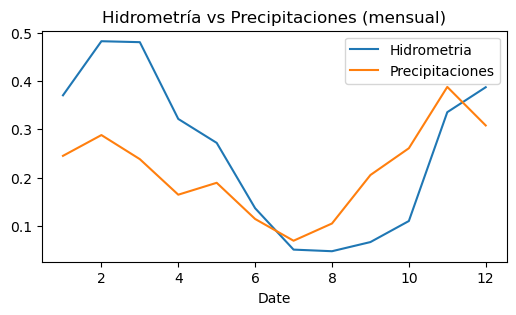

In [35]:
hydrom_vs_rainfall_monthly = df[['Hydrometry_Nave_di_Rosano', 'Mean_Rainfall']].resample('M') \
                            .agg(Hidrometria=('Hydrometry_Nave_di_Rosano', 'mean'), Precipitaciones=('Mean_Rainfall', 'mean'))

# Una normalización min-max parece buena opción, ya que al realizar previamente el agregado nos evitamos
# valores demasiado extremos
hydrom_vs_rainfall_monthly = (hydrom_vs_rainfall_monthly - hydrom_vs_rainfall_monthly.min()) / \
                            (hydrom_vs_rainfall_monthly.max() - hydrom_vs_rainfall_monthly.min())

index_monthly= hydrom_vs_rainfall_monthly.index.month
hydrom_vs_rainfall_monthly = hydrom_vs_rainfall_monthly.groupby(index_monthly).mean()

hydrom_vs_rainfall_monthly.plot(figsize=(6,3))
plt.title('Hidrometría vs Precipitaciones (mensual)')

plt.show()

Vemos que la tendencia es similar para ambas: llueve más y el río tiene más caudal en invierno, y ocurre lo contrario en verano.

Eso sí, la amplitud de la oscilación de la hidrometría es más grande. Se observa una tendencia llamativa:

_Parece que las lluvias tienen gran capacidad de provocar subidas del nivel del río en los meses de invierno (linea azul por encima de línea naranja), mientras que en verano ocurre lo contrario: aunque haya una cantidad apreciable de lluvia, no provoca un cambio muy acusado en los niveles del río._

Esto es un factor que puede que haya que tener en cuenta  a la hora de modelizar: las lluvias influyen claramente en los niveles del río (cuanto más llueve, más nivel lleva el río), pero no influyen de la misma forma en todas las épocas del año. Puede ocurrir por diferentes motivos: ¿mayor capacidad de drenado del suelo?, ¿mayor evaporación a causa de la temperatura?

Precisamente es la temperatura nuestra siguiente variable de estudio.

**CONCLUSIONES**

Como era de esperar, hay una estrecha relación entre la cantidad de precipitaciones y el nivel del río. Eso sí, hay ciertos matices en cómo cambia esta relación a lo largo del tiempo, que necesitaremos entender mejor antes de comenzar a modelar.

## 3.4 Análisis de la Temperatura

Recordemos que esta variable aún presentaba una pequeña cantidad de nulos, vamos a imputarlos.

In [36]:
# Imputamos los nulos para la temperatura, usando la media de cada mes
index_month = df.index.month
df_temp_by_month = df.Temperature_Firenze.groupby(index_month).mean().round(2).to_dict()

for month in range (1,13):
    df.loc[(df.Temperature_Firenze.isna()) & (df.index.month == month),'Temperature_Firenze']  = df_temp_by_month.get(month)
    
# Ya no tenemos ningún nulo en todo el DataFrame:
print('Número de nulos por variable:\n')
df.isna().sum()

Número de nulos por variable:



Temperature_Firenze          0
Hydrometry_Nave_di_Rosano    0
Mean_Rainfall                0
dtype: int64

Visualizamos toda la serie temporal:

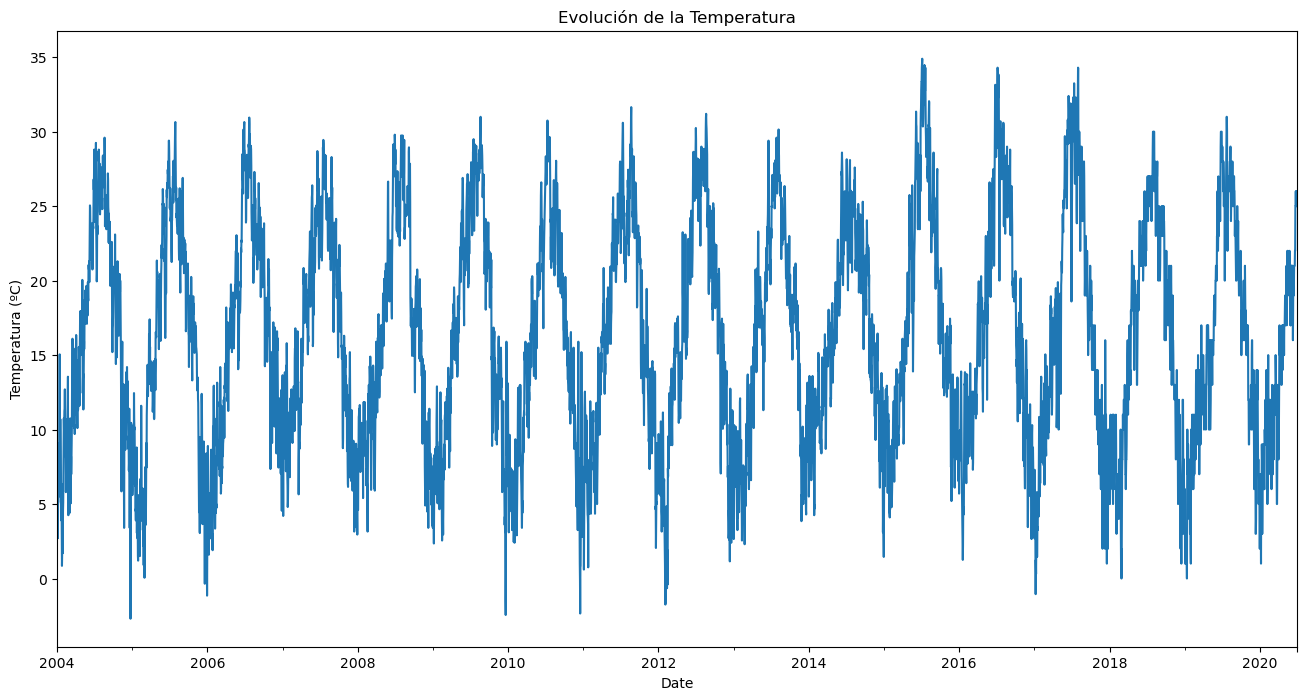

In [37]:
df.Temperature_Firenze.plot(figsize=(16,8))
plt.title('Evolución de la Temperatura')
plt.ylabel('Temperatura (ºC)')
plt.show()

Como era de esperar, hay un patrón cíclico en la temperatura. Para comparar de forma más clara cómo evoluciona este patrón en el tiempo, vamos a realizar nuevamente las visualizaciones de los datos agrupados por mes, y agrupados por año.

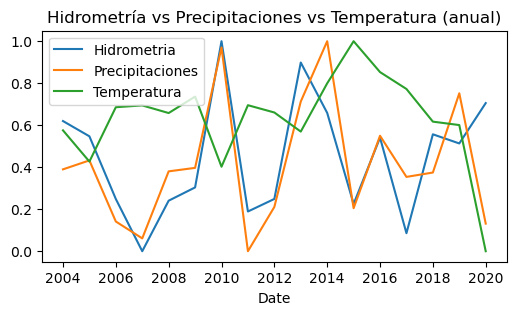

In [38]:
h_vs_r_vs_t_yearly = df.resample('Y').agg(Hidrometria=('Hydrometry_Nave_di_Rosano', 'mean'), 
                    Precipitaciones=('Mean_Rainfall', 'mean'), Temperatura=('Temperature_Firenze', 'mean'))

# Una normalización min-max parece buena opción, ya que al realizar previamente el agregado nos evitamos
# valores demasiado extremos
h_vs_r_vs_t_yearly = (h_vs_r_vs_t_yearly - h_vs_r_vs_t_yearly.min()) / \
                            (h_vs_r_vs_t_yearly.max() - h_vs_r_vs_t_yearly.min())

index_yearly= h_vs_r_vs_t_yearly.index.year
h_vs_r_vs_t_yearly = h_vs_r_vs_t_yearly.groupby(index_yearly).mean()

h_vs_r_vs_t_yearly.plot(figsize=(6,3))
plt.title('Hidrometría vs Precipitaciones vs Temperatura (anual)')

plt.show()

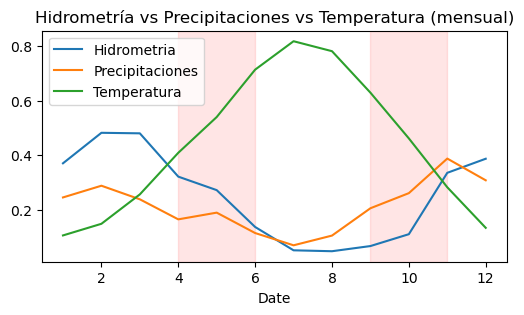

In [39]:
h_vs_r_vs_t_monthly = df.resample('M').agg(Hidrometria=('Hydrometry_Nave_di_Rosano', 'mean'), 
                    Precipitaciones=('Mean_Rainfall', 'mean'), Temperatura=('Temperature_Firenze', 'mean'))

# Una normalización min-max parece buena opción, ya que al realizar previamente el agregado nos evitamos
# valores demasiado extremos
h_vs_r_vs_t_monthly = (h_vs_r_vs_t_monthly - h_vs_r_vs_t_monthly.min()) / \
                            (h_vs_r_vs_t_monthly.max() - h_vs_r_vs_t_monthly.min())

index_monthly= h_vs_r_vs_t_monthly.index.month
h_vs_r_vs_t_monthly = h_vs_r_vs_t_monthly.groupby(index_monthly).mean()

ax = h_vs_r_vs_t_monthly.plot(figsize=(6,3))
ax.axvspan(4,6, color='red', alpha=0.1)
ax.axvspan(9,11, color='red', alpha=0.1)
plt.title('Hidrometría vs Precipitaciones vs Temperatura (mensual)')

plt.show()


Respecto a la pregunta lanzada anteriormente, de si la temperatura podría ser la causante de que las lluvias tengan más o menos efecto en las subidas del río. Parece que no hay una relación clara, comparemos lo que ocurre en los intervalos entre Abril-Junio y Septiembre-Noviembre (regiones sombreadas en rojo en el gráfico anterior): las temperaturas son similares, pero entre Abril y Junio las lluvias tienen mucho efecto sobre la hidrometría, mientras que en Septiembre-Noviembre, no tanto.

**CONCLUSIONES**

Las gráficas revelan el patrón que era de esperar: los años/meses más cálidos, tiende a llover menos, y los niveles del río tienden a ser más bajos.

# 4. Análisis exploratorio (Segunda Parte)

En el capítulo anterior, se ha realizado un análisis teniendo en cuenta todo el rango de datos de nuestra serie temporal.

Para poder captar relaciones más sutiles entre las variables, es necesario bajar más en el nivel de detalle, y eso es precisamente lo que haremos en este capítulo.

Como ya hemos aprendido, la evolución de las variables de nuestro dataset sigue un comportamiento cíclico anual. Vamos a aprovechar esta circunstancia para estudiar un año en concreto (2013), probablemente los patrones que detectemos en un año en particular, sean extrapolables a la totalidad del dataset.


Sabemos que las precipitaciones tienen gran influencia en las subidas de nivel del río. Vamos a representar las dos series temporales solapadas.

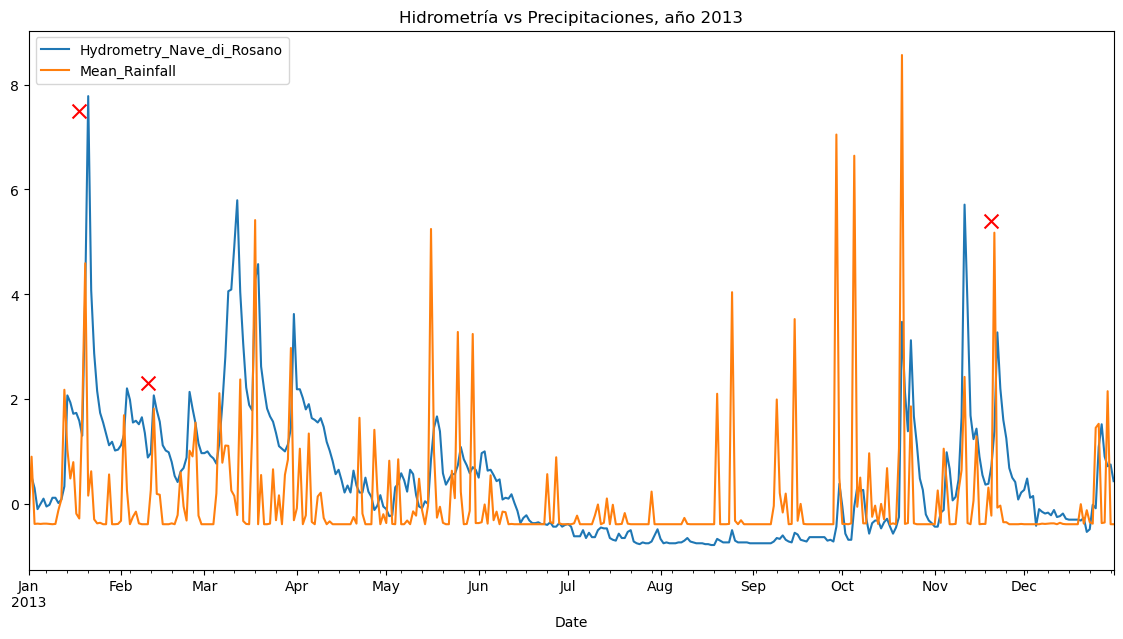

In [40]:
# Estandarizamos los datos para poder comparar ambas series
df_escalado = (df - df.mean())/df.std()

ax = df_escalado.loc['2013',['Hydrometry_Nave_di_Rosano','Mean_Rainfall']].plot(figsize=(14,7))

ax.scatter('2013-01-18', 7.5, c='r', marker='x', s=100)
ax.scatter('2013-02-10', 2.3, c='r', marker='x', s=100)
ax.scatter('2013-11-20', 5.4, c='r', marker='x', s=100)

plt.title('Hidrometría vs Precipitaciones, año 2013')

plt.show()

Aunque ese patrón se repite a lo largo de todo el año, fijémonos en los tres momentos marcados con las cruces rojas. En todas ellas comienza una subida en los niveles del río (pico en la línea azul), que coincide casi simultáneamente con un pico en las precipitaciones (línea naranja). Sin embargo, vemos que la línea naranja cae rápidamente, mientras que la azul cae de una forma mucho más amortiguada.

En otras palabras, parece que las lluvias en un determinado momento, afectan a los niveles del río durante varios días después de que hayan ocurrido.

Bajamos aún más al detalle (Enero-Febrero de 2013).

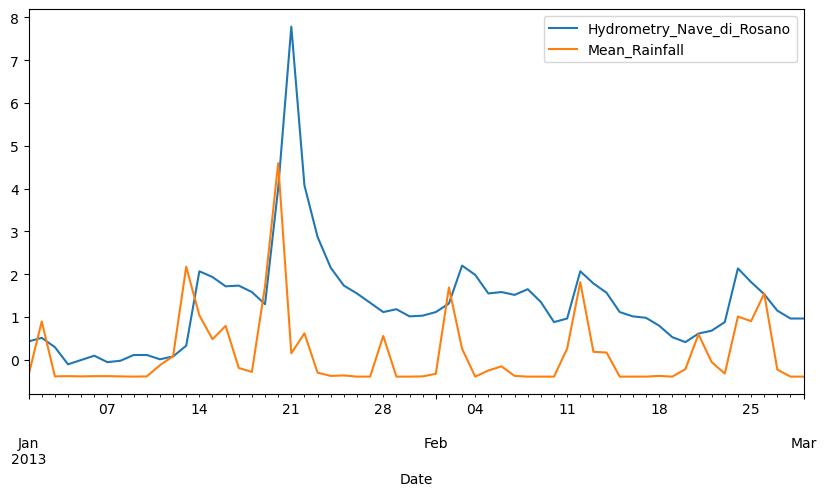

In [41]:
df_escalado.loc['2013-01-01':'2013-03-01',['Hydrometry_Nave_di_Rosano','Mean_Rainfall']].plot(figsize=(10,5))

plt.show()

A simple vista, en este intervalo temporal escogido, parece que las lluvias tardan aproximadamente un día en hacer efecto en los niveles del río, y dicho efecto se hace notar durante varios días, cada vez de forma más amortiguada. 

Dicho de otra forma, para predecir el nivel del río en un día en concreto, no vale con conocer lo que ha llovido ese mismo día. Es aún más importante conocer cuánto ha llovido los días anteriores.

Para poder estudiarlo de forma cuantitativa, vamos a hacer una suposición muy sencilla:

_Los niveles del río se pueden predecir, conociendo simplemente lo que ha llovido ese mismo día, y lo que ha llovido los días anteriores._

## 4.1 Explorando la influencia de las Precipitaciones - Modelo de regresión lineal

Para poner a prueba esta suposición, vamos a entrenar un modelo de regresión lineal utilizando datos de 2013. La variable objetivo (target), será la hidrometría de un día determinado. Las variables predictoras, serán las precipitaciones recogidas durante el mismo día, y durante los días anteriores. Una vez entrenado el modelo, realizaremos una predicción de los niveles del río en el año siguiente (2014), lo compararemos con los valores reales, y extraeremos conclusiones.

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

En primer lugar, tenemos que generar un dataset en el que para cada observación diaria, se tengan la precipitación de ese mismo día y la de varios días anteriores atrás.

In [43]:
df_rl = df.loc['2013',['Hydrometry_Nave_di_Rosano', 'Mean_Rainfall']].copy()

print('El dataset que utilizamos como punto de partida es:\n')

df_rl

El dataset que utilizamos como punto de partida es:



,Hydrometry_Nave_di_Rosano,Mean_Rainfall
Date,,
2013-01-01,1.75,0.28
2013-01-02,1.80,9.44
2013-01-03,1.67,0.04
2013-01-04,1.43,0.08
2013-01-05,1.49,0.04
...,...,...
2013-12-27,2.40,0.16
2013-12-28,2.03,0.24
2013-12-29,1.92,18.60


In [44]:
# Generamos el dataset que contenga las precipitaciones de días anteriores (hasta dos semanas, 14 días, de histórico)

for lag in range(1,15):
    df_rl['Rainfall_lag'+str(lag)] = df_rl['Mean_Rainfall'].shift(lag)

df_rl.dropna(inplace=True)

In [45]:
print('El dataset sobre el que realizaremos el modelado es:\n')

df_rl

El dataset sobre el que realizaremos el modelado es:



,Hydrometry_Nave_di_Rosano,Mean_Rainfall,Rainfall_lag1,Rainfall_lag2,Rainfall_lag3,Rainfall_lag4,Rainfall_lag5,Rainfall_lag6,Rainfall_lag7,Rainfall_lag8,Rainfall_lag9,Rainfall_lag10,Rainfall_lag11,Rainfall_lag12,Rainfall_lag13,Rainfall_lag14
Date,,,,,,,,,,,,,,,,
2013-01-15,2.65,6.40,10.48,18.80,3.48,1.96,0.04,0.00,0.04,0.08,0.08,0.04,0.08,0.04,9.44,0.28
2013-01-16,2.52,8.68,6.40,10.48,18.80,3.48,1.96,0.04,0.00,0.04,0.08,0.08,0.04,0.08,0.04,9.44
2013-01-17,2.53,1.48,8.68,6.40,10.48,18.80,3.48,1.96,0.04,0.00,0.04,0.08,0.08,0.04,0.08,0.04
2013-01-18,2.44,0.80,1.48,8.68,6.40,10.48,18.80,3.48,1.96,0.04,0.00,0.04,0.08,0.08,0.04,0.08
2013-01-19,2.27,15.48,0.80,1.48,8.68,6.40,10.48,18.80,3.48,1.96,0.04,0.00,0.04,0.08,0.08,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-27,2.40,0.16,14.04,13.48,0.08,0.28,1.96,0.08,2.80,0.00,0.00,0.00,0.00,0.00,0.04,0.20
2013-12-28,2.03,0.24,0.16,14.04,13.48,0.08,0.28,1.96,0.08,2.80,0.00,0.00,0.00,0.00,0.00,0.04
2013-12-29,1.92,18.60,0.24,0.16,14.04,13.48,0.08,0.28,1.96,0.08,2.80,0.00,0.00,0.00,0.00,0.00


Entrenamos el modelo con datos de 2013, predecimos con datos de 2014, visualizamos datos reales vs predicciones.

In [46]:
# Entrenamos el modelo

X_train=df_rl.drop(columns=['Hydrometry_Nave_di_Rosano'])

y_train=df_rl['Hydrometry_Nave_di_Rosano'].copy()

lineal = LinearRegression().fit(X_train,y_train)

In [47]:
# Preparamos datos de test (2014) y predecimos

df_test = df.loc['2014',['Hydrometry_Nave_di_Rosano','Mean_Rainfall']].copy()

for lag in range(1,15):
    df_test['Rainfall_lag'+str(lag)] = df_test['Mean_Rainfall'].shift(lag)

df_test.dropna(inplace=True)

X_test=df_test.drop(columns=['Hydrometry_Nave_di_Rosano'])

y_test=df_test['Hydrometry_Nave_di_Rosano'].copy()


y_pred = lineal.predict(X_test)

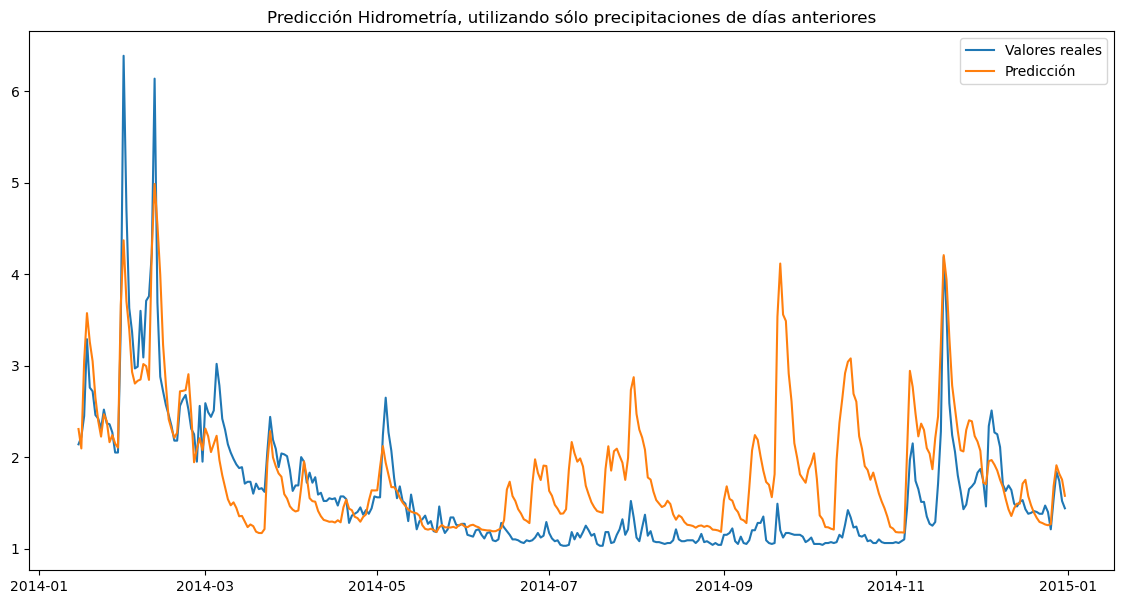

In [48]:
plt.figure(figsize=(14,7))
ax = plt.plot(df_test.index.to_list(), y_test)
ax[0].set_label('Valores reales')
ax = plt.plot(df_test.index.to_list(), y_pred)
ax[0].set_label('Predicción')
plt.legend()
plt.title('Predicción Hidrometría, utilizando sólo precipitaciones de días anteriores')

plt.show()

Vemos cómo las precipitaciones de días anteriores tienen gran capacidad de predicción sobre los niveles del río. El modelo tiene gran capacidad para predecir las subidas y bajadas de los niveles del río. En otras palabras, la FORMA de la línea azul  y la línea naranja de los gráficos anteriores es muy similar.

Ahora bien, como ya habíamos adelantado en el análisis de tendencias generales, vemos cómo las precipitaciones no influyen de la misma forma en todos los meses del año. El modelo predice de más en los meses de verano (porque las lluvias en esa época, en realidad, tienen menor capacidad de influencia en los niveles del río de la que el modelo está suponiendo), y predice de menos en invierno.

En cuanto a la capacidad de influencia que tienen las precipitaciones de un día en concreto en los niveles del río, según van pasando los días: extraemos la importancia de cada feature en el modelo.

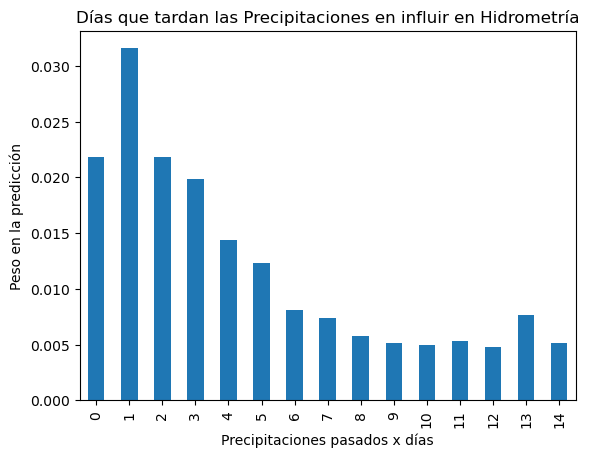

In [49]:
ax = pd.DataFrame(lineal.coef_).plot(kind='bar')
plt.xlabel('Precipitaciones pasados x días')
plt.ylabel('Peso en la predicción')
ax.get_legend().remove()
plt.title('Días que tardan las Precipitaciones en influir en Hidrometría')

plt.show()

Vemos que cuando más efecto hacen las lluvias en los niveles del río es un día después de que ocurran. La influencia va decayendo progresivamente a medida que pasan los días.

**CONCLUSIONES**

Las precipitaciones tienen gran peso en la predicción de los niveles del río. Pero falta por encontrar un factor que nos ayude a comprender la variación en la influencia de las precipitaciones en diferentes épocas del año.

## 4.2 Búsqueda de variables predictoras adicionales - Modelo de Random Forest

Vamos a proponer varias variables que pueden ser candidatas para explicar esa variación. Esta vez, utilizamos un modelo de Random Forest en lugar de regresión lineal, ya que puede ser que alguna de las candidatas tenga una relación no lineal con la target.

- En primer lugar tenemos la **"Temperatura"**: hemos visto anteriormente que en los meses de mayor Temperatura, menor es la influencia de las Precipitaciones en la Hidrometría.


- En segundo lugar, podemos suponer que la capacidad de drenado del suelo está influida por lo que haya llovido en meses anteriores. Así que probaremos **"Precipitaciones acumuladas (últimos 90 días)".**


- En tercer lugar lugar, tenemos el **"Momento del año"**: es posible que la variación en la influencia de las precipitaciones dependa fuertemente del momento del año que se esté observando.

Para introducir el Momento del año como variable de estudio, se va a transformar cada fecha del año en dos variables: Año_seno, y Año_coseno. Se incluye la siguiente visualización para ilustrar cómo funcionaría esta transformación, tomando un año en concreto.

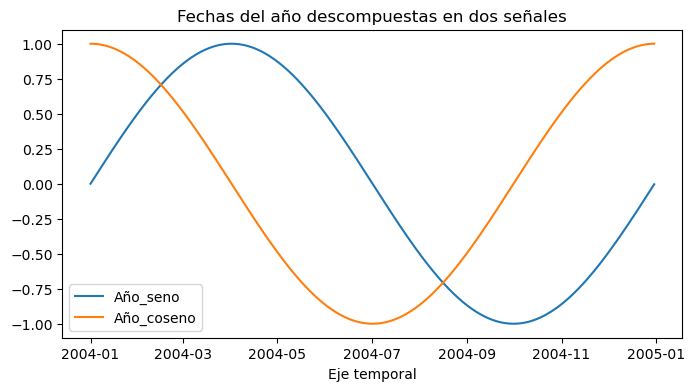

In [50]:
plt.figure(figsize=(8,4))
axes = plt.plot(df.loc['2004'].index.to_list(), np.sin(np.arange(len(df.loc['2004'])) * (2 * np.pi / 365.2425)))
axes[0].set_label('Año_seno')
axes = plt.plot(df.loc['2004'].index.to_list(), np.cos(np.arange(len(df.loc['2004'])) * (2 * np.pi / 365.2425)))
axes[0].set_label('Año_coseno')
plt.xlabel('Eje temporal')
plt.title('Fechas del año descompuestas en dos señales')
plt.legend()

plt.show()

Vemos como, utilizando estas dos señales, se puede identificar de forma única cada momento del año (puede ser que dos momentos del año tengan valores de Año_seno iguales, pero sus valores de Año_coseno serán diferentes, y viceversa).

Para cada una de estas tres variables que ensayaremos (Temperatura, Precipitaciones acumuladas, Momento del año), la metodología a seguir será idéntica:

- Utilizaremos como datos de entrenamiento tres años (2011, 2012, 2013)


- Utilizaremos las precipitaciones de los 7 días anteriores, más la variable a ensayar en cada iteración


- Predeciremos Hidrometría para el año 2014. Visualizamos predicción vs realidad, obtenemos métrica: error absoluto medio ("mae")

### 4.2.1 Preprocesado de datos, definición de funciones

In [51]:
from sklearn.ensemble import RandomForestRegressor

Generamos el dataframe necesario para el estudio, añadiéndole las tres variables predictoras que queremos ensayar.

In [52]:
# Punto de partida: dataframe con la target, y los lluvias de hasta 7 días anteriores
df_rainfalls = df.loc['2011':'2014',['Hydrometry_Nave_di_Rosano', 'Mean_Rainfall']].copy()
for lag in range(1,8):
    df_rainfalls['Rainfall_lag'+str(lag)] = df_rainfalls['Mean_Rainfall'].shift(lag)

# Añadimos las variables de ensayo al dataframe:

# Temperatura
df_rainfalls['Temperature'] =  df.loc['2011':'2014',['Temperature_Firenze']].copy()
# Precipitaciones acumuladas
df_rainfalls['Cumulative_Rainfall'] =  df_rainfalls['Mean_Rainfall'].rolling(90).mean()
# Momento del año
df_rainfalls['Year_sin'] = np.sin(np.arange(len(df_rainfalls)) * (2 * np.pi / 365.2425))
df_rainfalls['Year_cos'] = np.cos(np.arange(len(df_rainfalls)) * (2 * np.pi / 365.2425))

df_rainfalls.dropna(inplace=True)

df_rainfalls.head()

,Hydrometry_Nave_di_Rosano,Mean_Rainfall,Rainfall_lag1,Rainfall_lag2,Rainfall_lag3,Rainfall_lag4,Rainfall_lag5,Rainfall_lag6,Rainfall_lag7,Temperature,Cumulative_Rainfall,Year_sin,Year_cos
Date,,,,,,,,,,,,,
2011-03-31,2.00,0.0,0.0,0.32,31.64,3.76,0.00,0.00,0.00,16.25,3.068444,0.999210,0.039739
2011-04-01,1.77,0.0,0.0,0.00,0.32,31.64,3.76,0.00,0.00,15.80,3.067556,0.999746,0.022544
2011-04-02,1.83,0.0,0.0,0.00,0.00,0.32,31.64,3.76,0.00,16.50,3.067556,0.999986,0.005344
2011-04-03,1.68,0.0,0.0,0.00,0.00,0.00,0.32,31.64,3.76,16.55,3.067556,0.999930,-0.011859
2011-04-04,1.75,0.0,0.0,0.00,0.00,0.00,0.00,0.32,31.64,15.55,3.067556,0.999578,-0.029058


Definición de funciones.

In [53]:
# Función que genera los conjuntos de train y test necesarios para cada una de las variables de ensayo
# (features) que utilizaremos

def genera_train_test(df, feature):
    feature_list = ['Mean_Rainfall', 'Rainfall_lag1',
       'Rainfall_lag2', 'Rainfall_lag3', 'Rainfall_lag4', 'Rainfall_lag5',
       'Rainfall_lag6', 'Rainfall_lag7'] + feature
    X_train = df.loc['2011':'2013', feature_list].copy()
    y_train = df['Hydrometry_Nave_di_Rosano'].loc['2011':'2013'].copy()

    X_test = df.loc['2014', feature_list].copy()
    y_test = df['Hydrometry_Nave_di_Rosano'].loc['2014'].copy()
    
    return X_train, y_train, X_test, y_test

In [54]:
# Función que dibuja comparativamente datos reales y predicciones para el conjunto de test

def plot_test_pred(y_test, y_pred, texto_titulo, df=df_rainfalls):
    plt.figure(figsize=(14,7))
    ax = plt.plot(df.loc['2014'].index.to_list(), y_test)
    ax[0].set_label('Valores reales')
    ax = plt.plot(df.loc['2014'].index.to_list(), y_pred)
    ax[0].set_label('Predicción')
    plt.legend()
    plt.title(f'Predicción Hidrometría: Precipitaciones {texto_titulo}')

plt.show()

In [55]:
# Almacenaremos las métricas en un diccionario

metricas = {}

### 4.2.2 Establecemos baseline: predicciones sólo con Precipitaciones, sin tener en cuenta las variables de ensayo

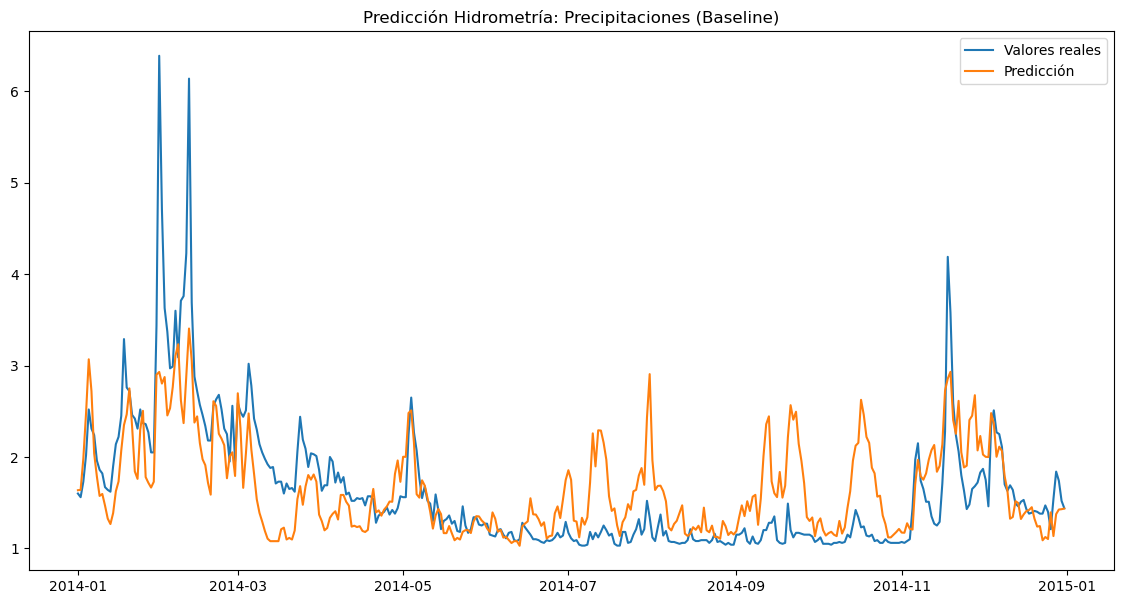

In [56]:
feature = []

X_train, y_train, X_test, y_test = genera_train_test(df_rainfalls, feature)

y_pred = RandomForestRegressor().fit(X_train, y_train).predict(X_test)

plot_test_pred(y_test, y_pred, '(Baseline)')

In [57]:
metricas['Baseline'] = round(mean_absolute_error(y_test, y_pred),2)
print(f'El error absoluto medio en la predicción del nivel del río es: {mean_absolute_error(y_test, y_pred):.2f} metros')

El error absoluto medio en la predicción del nivel del río es: 0.38 metros


### 4.2.3 Temperatura

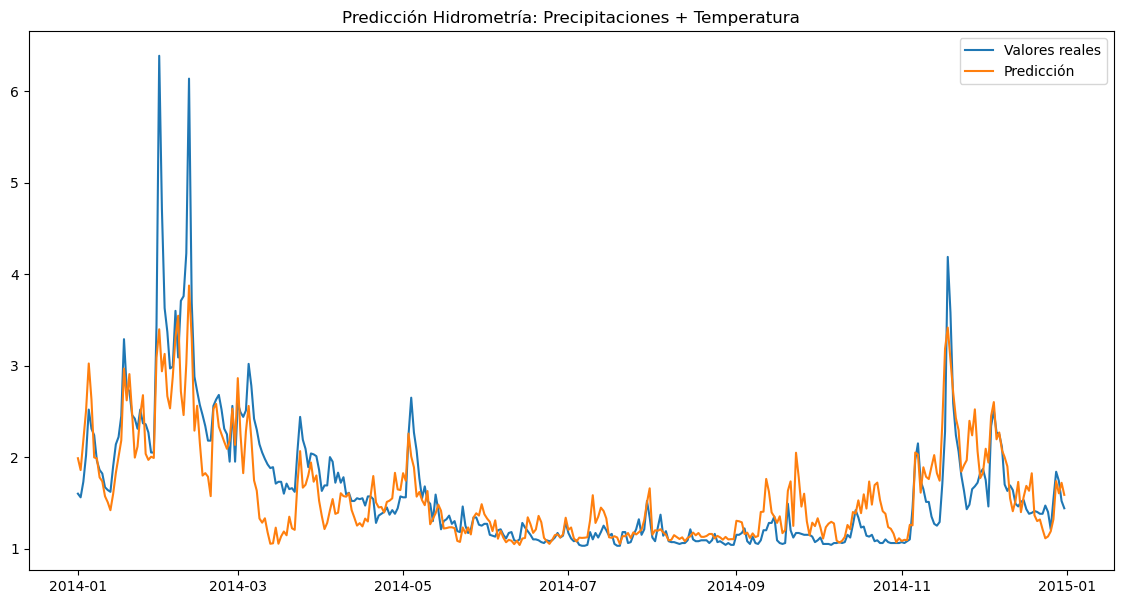

In [58]:
feature = ['Temperature']

X_train, y_train, X_test, y_test = genera_train_test(df_rainfalls, feature)

y_pred = RandomForestRegressor().fit(X_train, y_train).predict(X_test)

plot_test_pred(y_test, y_pred, '+ Temperatura')

In [59]:
metricas['Temperatura'] = round(mean_absolute_error(y_test, y_pred),2)
print(f'El error absoluto medio en la predicción del nivel del río es: {mean_absolute_error(y_test, y_pred):.2f} metros')

El error absoluto medio en la predicción del nivel del río es: 0.24 metros


### 4.2.4 Precipitaciones acumuladas

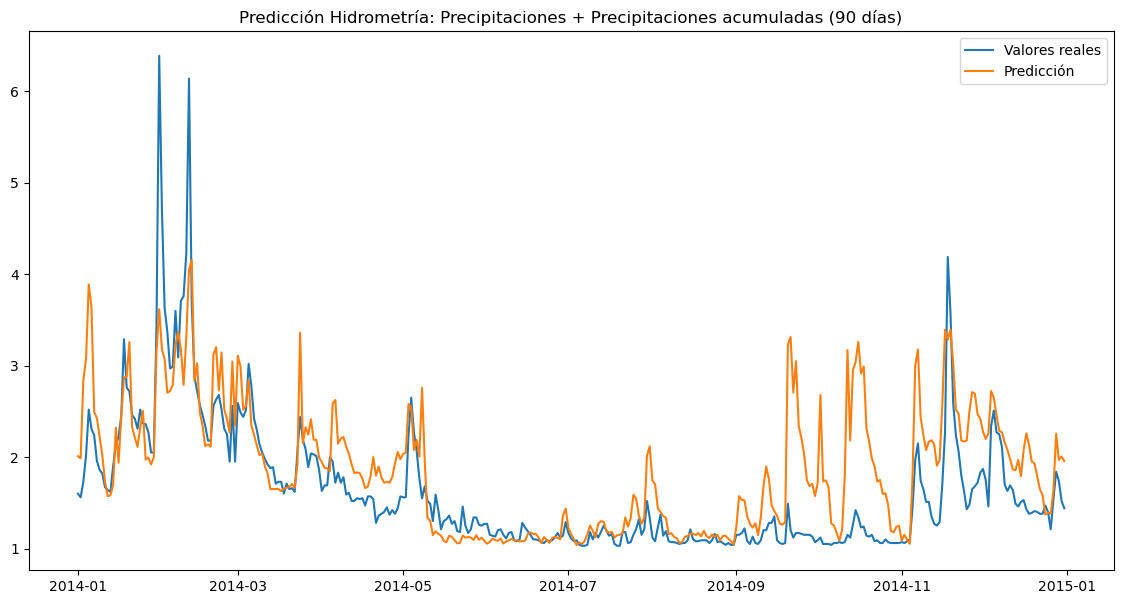

In [60]:
feature = ['Cumulative_Rainfall']

X_train, y_train, X_test, y_test = genera_train_test(df_rainfalls, feature)

y_pred = RandomForestRegressor().fit(X_train, y_train).predict(X_test)

plot_test_pred(y_test, y_pred, '+ Precipitaciones acumuladas (90 días)')

In [61]:
metricas['Precipitaciones acumuladas'] = round(mean_absolute_error(y_test, y_pred),2)
print(f'El error absoluto medio en la predicción del nivel del río es: {mean_absolute_error(y_test, y_pred):.2f} metros')

El error absoluto medio en la predicción del nivel del río es: 0.36 metros


### 4.2.5 Momento del año

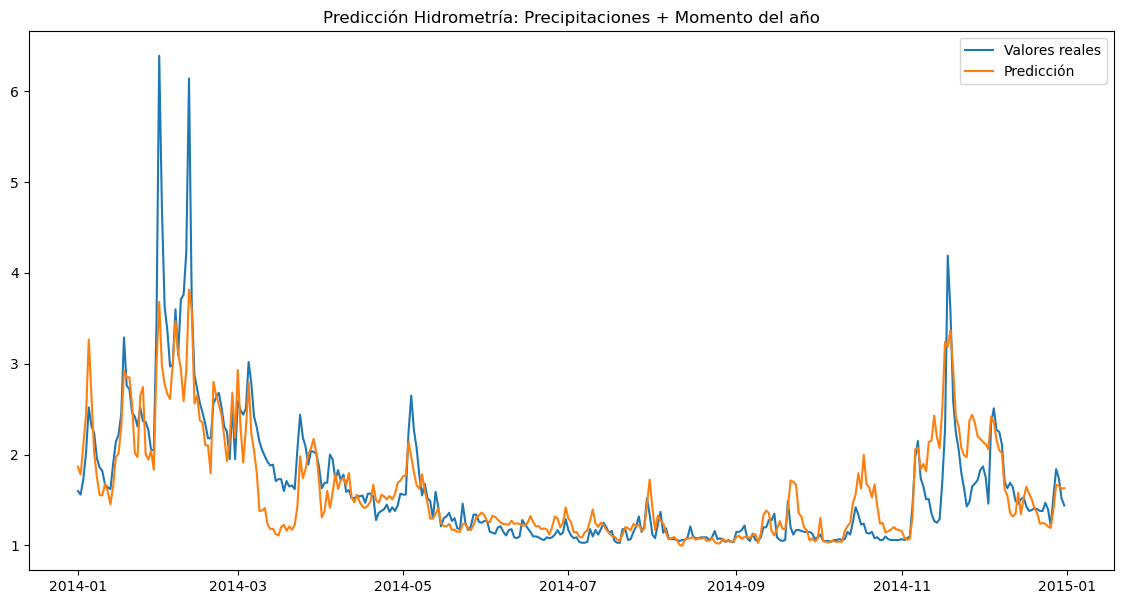

In [62]:
feature = ['Year_sin', 'Year_cos']

X_train, y_train, X_test, y_test = genera_train_test(df_rainfalls, feature)

y_pred = RandomForestRegressor().fit(X_train, y_train).predict(X_test)

plot_test_pred(y_test, y_pred, '+ Momento del año')

In [63]:
metricas['Momento del año'] = round(mean_absolute_error(y_test, y_pred),2)
print(f'El error absoluto medio en la predicción del nivel del río es: {mean_absolute_error(y_test, y_pred):.2f} metros')

El error absoluto medio en la predicción del nivel del río es: 0.22 metros


### 4.2.6 Resumen y conclusiones

Comparamos visualmente las diferentes gráficas obtenidas, mostramos los valores del error absoluto medio utilizando cada una de las variables de ensayo propuestas.

In [64]:
metricas

{'Baseline': 0.38,
 'Temperatura': 0.24,
 'Precipitaciones acumuladas': 0.36,
 'Momento del año': 0.22}

Vemos que la variable de ensayo "Cumulative Rainfall" es la que parece menos prometedora, no consigue mejorar la métrica que teníamos para la baseline. Respecto a las otras dos variables ("Temperatura", "Momento del Año"), vemos que sí que consiguen bajar el error absoluto medio de la predicción. 

En las gráficas observamos cómo, utilizando estas dos variables, se consigue amortiguar en cierta medida los errores en las predicciones en los que incurría el modelo Baseline, especialmente en verano. Ahora bien, estos modelos siguen teniendo margen de mejora: predicen de menos cuando ocurren grandes subidas del nivel del río, y hay determinados tramos del año donde las predicciones se desvían bastante.

**CONCLUSIONES**

"Temperatura" y "Momento del Año" parecen variables que ayudan a mejorar las predicciones, "Precipitaciones acumuladas" no, hay margen de mejora para seguir buscando otras variables que ayuden a mejorar las predicciones. También se podría intentar estudiar el efecto de combinar varias de estas variables de ensayo en el modelado.

Por ahora, decidimos no ahondar más en esta cuestión. Se incluirán en el modelado las dos variables que mejoran las predicciones: "Temperatura" y "Momento del año".

# 5. Modelado

## 5.1 Consideraciones previas

Una vez concluido el análisis exploratorio de datos, llega el momento de utilizar un modelo para obtener predicciones de la hidrometría. En este sentido, hay dos decisiones que son clave:

- Elección del horizonte temporal de la predicción: ¿Para qué necesita una compañía de aguas conocer con antelación los niveles de un río? ¿Qué uso práctico se le pretende dar a esas predicciones? La respuesta a estas preguntas condicionará los horizontes temporales (días, semanas, meses) que escojamos para realizar nuestras predicciones.


- Elección del modelo: Con todo lo que hemos aprendido de los datos en capítulos previos, ¿qué tipo de modelo puede ser el apropiado para obtener predicciones precisas?

### 5.1.1 Horizonte temporal de la predicción

Rescatamos una frase textual que escribe la propia compañía gestora de aguas que subió este desafío a la web:

- _"The time interval is defined as day/month depending on the available measures for each waterbody. Models should capture volumes for each waterbody (for instance, for a model working on a monthly interval a forecast over the month is expected)."_

En nuestro caso, el intervalo de tiempo entre cada observación es un día, así que uno de los horizontes temporales que vamos a predecir, son los niveles del río **al día siguiente**. 

Pero además, aunque no lo especifique la compañía en el desafío, vamos a realizar predicciones para un horizonte temporal más largo. Veremos que este tipo de predicciones plantean un desafío adicional, y esto ayudará a que podamos ahondar en nuestra comprensión sobre esta serie temporal.

Por tanto, elegimos un segundo horizonte temporal que sean **dos semanas**. Muchas predicciones meteorológicas suelen tener este horizonte temporal, y necesitaremos alimentar al modelo con las predicciones de lluvia y temperatura para poder hacer predicciones a largo plazo. De todas formas, como se verá más adelante, la metodología que se utilizará para hacer predicciones a dos semanas vista, se puede replicar perfectamente para un horizonte temporal más largo o más corto. Bastará con disponer de predicciones meteorológicas para el horizonte temporal que escojamos.

### 5.1.2 Modelo utilizado

En el capítulo de análisis exploratorio de datos, ya hemos utilizado un modelo de regresión lineal, y un modelo de random forest. Para realizar el modelado final, vamos a escoger un modelo más adaptado a series temporales, y que debería de tener más potencial que los anteriores: **redes neuronales recurrentes LSTM**.

## 5.2 Modelado con Redes Neuronales Recurrentes LSTM

Para realizar las predicciones de nuestra serie temporal, se implementará un algoritmo de redes neuronales recurrentes LSTM desarrollado por Tensorflow. El código utilizado es una adaptación para nuestro caso particular del ejemplo que se utiliza como guía-tutorial en la propia página web de Tensorflow para predecir series temporales con redes neuronales.

https://www.tensorflow.org/tutorials/structured_data/time_series

### 5.2.1 Preprocesado de datos

Como ya se había adelantado en el capítulo de análisis exploratorio, se van a utilizar como variables predictoras: **Precipitaciones, Temperatura, y Momento del año** (Señal seno y coseno de frecuencia anual). Además, la elección de este modelo nos condiciona a tomar otras dos decisiones:

   - También se va a incluir la propia **Hidrometría** como variable predictora de ella misma.
   
   - No sólo se van a utilizar los **valores de varios días anteriores (siete)** de las Precipitaciones. **Se van a utilizar los valores de 7 días anteriores de todas las variables predictoras**.
    
El código utilizado en el tutorial de Tensorflow, está adaptado para tomar como inputs tanto los valores de la propia variable target, como los valores de días anteriores de todas las variables predictoras. Se podría hacer un análisis muy minucioso para intentar modificar con más profundidad el código, y poder ensayar sólo con las variables que más interés apuntaban en el capítulo de análisis exploratorio. Pero se considera que ese análisis se escapa del alcance de este proyecto. Además, tanto la inclusión de la Hidrometría como de los valores de días anteriores de todas las variables, es improbable que tengan una influencia negativa en los resultados (quizá, todo lo contrario).


Así, lo que primero hemos de hacer, es incluir en el dataframe las señales Seno y Coseno para determinar el momento del año:

In [65]:
df['Year_sin'] = np.sin(np.arange(len(df)) * (2 * np.pi / 365.2425))
df['Year_cos'] = np.cos(np.arange(len(df)) * (2 * np.pi / 365.2425))

A continuación, dividimos los datos en los conjuntos de train, validación y test. Se hace por intervalos temporales consecutivos y en orden cronológico, las divisiones elegidas son las siguientes:

   - Conjunto de Train: años 2004 a 20016
   - Conjunto de Validación: años 2017 a 2018
   - Conjunto de Test: año 2019 hasta Final de la serie (2020-06-30)

In [66]:
train_df = df.loc[:'2016'].copy()
val_df = df.loc['2017':'2018'].copy()
test_df = df.loc['2019':].copy()

Para realizar el entrenamiento de la red, se utilizarán datos normalizados para todos los conjuntos de datos.

In [67]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [68]:
train_df.head()

,Temperature_Firenze,Hydrometry_Nave_di_Rosano,Mean_Rainfall,Year_sin,Year_cos
Date,,,,,
2004-01-01,-1.056027,0.580601,-0.379358,3.310437e-07,1.413686
2004-01-02,-1.265387,0.730969,-0.390321,2.432714e-02,1.413477
2004-01-03,-1.481502,0.196326,-0.390321,4.864675e-02,1.412849
2004-01-04,-1.744891,-0.238072,-0.390321,7.295197e-02,1.411804
2004-01-05,-1.859701,-0.087703,-0.384839,9.723559e-02,1.410340


### 5.2.2 Clases y funciones

Se declaran las clases y funciones que se utilizarán durante el modelado.

In [69]:
import tensorflow as tf

In [70]:
class WindowGenerator():
  """
  Clase que se utilizará para definir las ventanas temporales con las que se
  alimentará al modelo para entrenarlo y para realizar las predicciones.
    
  Introducimos como argumentos: input_width (número de días anteriores a utilizar para
  las variables predictoras), label_width (número de días a predecir), shift (días que transcurren
  entre los valores usados para predecir, y el día que se quiere predecir)
  """
    
    
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Índices de los días predictores: {self.input_indices}',
        f'Índices de los días a predecir: {self.label_indices}',
        f'Variables objetivo: {self.label_columns}'])

In [71]:
def split_window(self, features):
  """
  Función que divide las ventanas de datos, en una ventana para las variables predictoras,
  y otra para las variables objetivo
  """

  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [72]:
def make_dataset(self, data):
  """
  Función que puebla con los datos definidos en un dataframe, los tensores que se han de generar
  teniendo en cuenta las ventanas temporales con las que se quiere trabajar
  """

  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [73]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)


WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test

### 5.2.3 Entrenamiento del modelo

Definimos la ventana de predicción que vamos a usar: utilizando los datos de los últimos 7 días, predecir la hidrometría del día siguiente.

In [74]:
ventana_prediccion = WindowGenerator(
    input_width=7,
    label_width=1,
    shift=1,
    label_columns=['Hydrometry_Nave_di_Rosano'])

ventana_prediccion

Índices de los días predictores: [0 1 2 3 4 5 6]
Índices de los días a predecir: [7]
Variables objetivo: ['Hydrometry_Nave_di_Rosano']

Definimos la arquitectura de la red e instanciamos el modelo.

In [75]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=32),
    tf.keras.layers.Dense(units=1)
])

Compilamos el modelo y lo entrenamos con los datos del conjunto de train, pasándole como argumento esa ventana_prediccion que creamos previamente. Es decir, el modelo será entrenado para aprender cómo ha de asignar los pesos teniendo en cuenta las variables predictoras para los últimos 7 días, de forma que se obtenga la predicción más precisa posible para la variable target al día siguiente.

In [76]:
MAX_EPOCHS = 20

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min')

lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

history = lstm_model.fit(ventana_prediccion.train, epochs=20,
                      validation_data=ventana_prediccion.val,
                      callbacks=[early_stopping])

history

Epoch 1/20
149/149 [==============================] - 5s 10ms/step - loss: 0.4022 - mean_absolute_error: 0.3560 - val_loss: 0.1972 - val_mean_absolute_error: 0.2443
Epoch 2/20
149/149 [==============================] - 1s 7ms/step - loss: 0.2330 - mean_absolute_error: 0.2532 - val_loss: 0.1608 - val_mean_absolute_error: 0.2156
Epoch 3/20
149/149 [==============================] - 1s 7ms/step - loss: 0.1922 - mean_absolute_error: 0.2282 - val_loss: 0.1521 - val_mean_absolute_error: 0.2074
Epoch 4/20
149/149 [==============================] - 1s 7ms/step - loss: 0.1760 - mean_absolute_error: 0.2170 - val_loss: 0.1501 - val_mean_absolute_error: 0.2021
Epoch 5/20
149/149 [==============================] - 1s 7ms/step - loss: 0.1673 - mean_absolute_error: 0.2104 - val_loss: 0.1498 - val_mean_absolute_error: 0.1976
Epoch 6/20
149/149 [==============================] - 1s 7ms/step - loss: 0.1614 - mean_absolute_error: 0.2055 - val_loss: 0.1501 - val_mean_absolute_error: 0.1935
Epoch 7/20
149/

Evaluamos la precisión del modelo, comparando sus predicciones contra los valores reales del conjunto de test.

In [77]:
# Generamos un dataframe que contenga los valores reales (conjunto de test)
real_vs_preds = pd.DataFrame(test_df.loc['2019-01-08':,'Hydrometry_Nave_di_Rosano'])\
    .rename(columns = {'Hydrometry_Nave_di_Rosano':'Real'})

# Y le adjuntamos una columna que contenga las predicciones
real_vs_preds['Prediccion'] = lstm_model.predict(ventana_prediccion.test).flatten()

17/17 [==============================] - 1s 2ms/step


Deshacemos la normalización aplicada a los datos, para devolverlos a su escala real.

In [78]:
real_vs_preds = real_vs_preds * train_std['Hydrometry_Nave_di_Rosano'] + train_mean['Hydrometry_Nave_di_Rosano']
real_vs_preds.head()

,Real,Prediccion
Date,,
2019-01-08,1.27,1.104980
2019-01-09,1.11,1.157083
2019-01-10,1.22,1.119274
2019-01-11,1.08,1.145998
2019-01-12,1.24,1.090864


Visualizamos conjuntamente valores reales y predicciones del modelo, para todo el intervalo temporal comprendido en el conjunto de test (de Enero de 2019 a Junio de 2020):

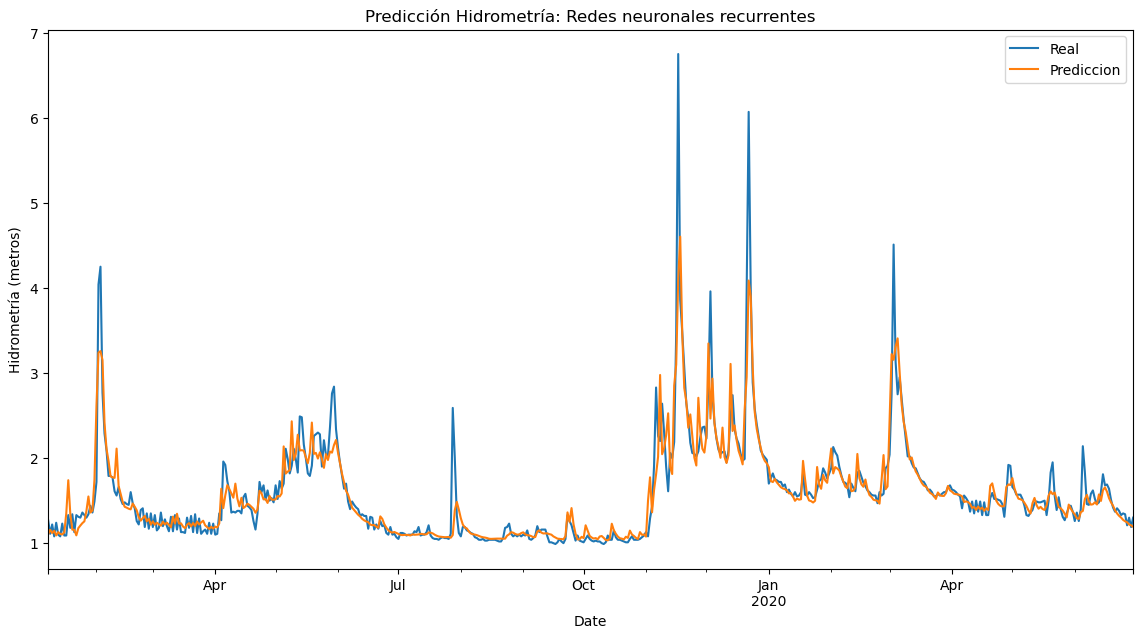

In [79]:
real_vs_preds.plot(figsize=(14,7))
plt.ylabel('Hidrometría (metros)')
plt.title('Predicción Hidrometría: Redes neuronales recurrentes')

plt.show()

Visualizamos también la serie temporal de la diferencia entre valores reales y predicción:

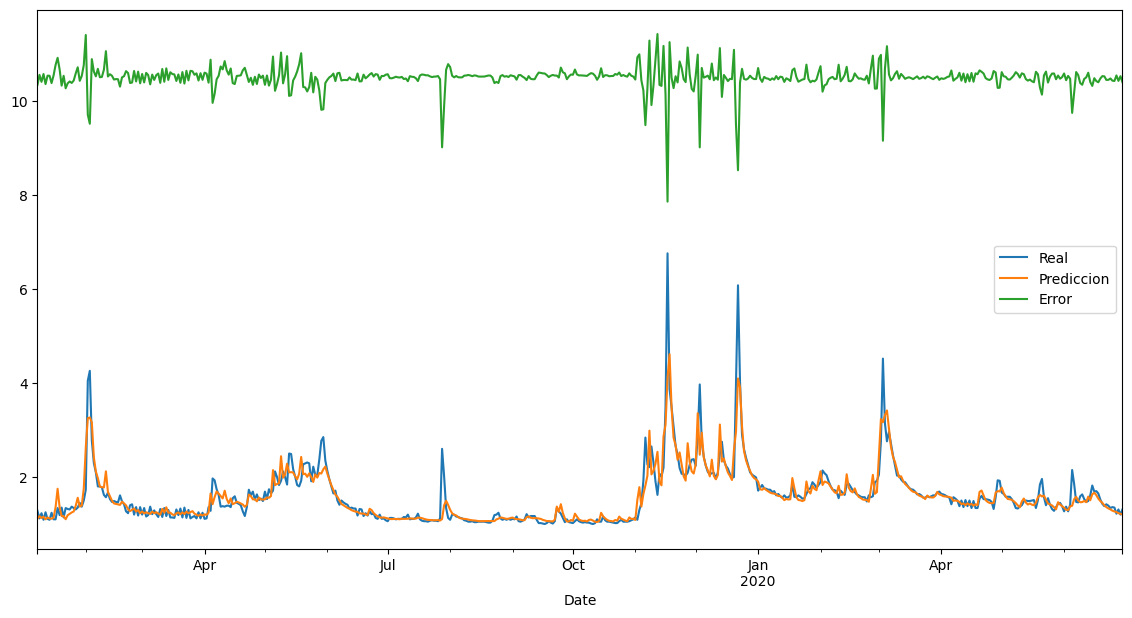

In [80]:
real_vs_preds['Error'] = (real_vs_preds['Prediccion'] - real_vs_preds['Real']) + 10.5
real_vs_preds.plot(figsize=(14,7))
plt.show()

In [81]:
print(f'El error absoluto medio en la predicción del nivel del río es: \
      {mean_absolute_error(real_vs_preds["Real"], real_vs_preds["Prediccion"]):.2f} metros')

El error absoluto medio en la predicción del nivel del río es:       0.13 metros


Tanto a nivel visual como cuantitativo (métrica de error absoluto), vemos cómo las predicciones del modelo de redes neuronales recurrentes mejoran ostensiblemente a aquellas obtenidas con los modelos de regresión lineal y random forest utilizados en el anterior capítulo.

Se han cambiado diferentes parámetros con respecto a aquellos ensayos, además del modelo escogido: hemos entrenado con los datos de todo el histórico, hemos utilizado un conjunto de test diferente, hemos utilizado como variables predictoras los valores de días anteriores de todas las variables y no sólo de las precipitaciones... En definitiva, por uno o varios de estos motivos, las predicciones obtenidas han mejorado mucho.

Vemos cómo las predicciones (línea naranja) y los valores reales (línea azul) siempre son muy similares. Sea cual sea la época del año, el modelo capta correctamente la influencia de las precipitaciones en todos los momentos del año. Ya no ocurre aquello observado para regresión lineal y random forest, que en algunos tramos del año ambas líneas se "despegaban" mucho la una de la otra.

En la segunda visualización, donde se incluye la serie temporal de los errores, se ve cómo éstos siempre coinciden con los momentos en los que aumenta y disminuye bruscamente el nivel del río, independientemente de la época del año en la que esta ocurra (evidentemente, cuanto más bruscas sean las subidas y bajadas, más error en las predicciones). Los mayores errores se producen justamente los días en los que se producen grandes crecidas del río, en las cuales el modelo tiende a predecir niveles más bajos de lo real (picos hacia abajo de la línea verde).

# 6. Obtención de predicciones a futuro - diferentes horizontes temporales

Una vez ya se ha entrenado el modelo y se ha validado su comportamiento, el paso final consiste en realizar predicciones de valores futuros, simulando cómo una compañía gestora de aguas podría sacar provecho de este modelo. Como ya se había comentado, se ofrecerán predicciones para dos horizontes temporales diferentes: estimaremos los niveles del río para el día siguiente, y para dentro de dos semanas.

## 6.1 Predicción al día siguiente

Ya que nuestro conjunto de datos finaliza el 2020-06-30, se va a obtener la predicción de cómo estará el nivel del río al día siguiente: 2020-07-01.

Se genera el conjunto de variables predictoras: valores de las mismas para los 7 días anteriores al día que se quiere ofrecer la predicción.

In [82]:
df_prediccion = test_df.loc['2020-06-24':]
df_prediccion = df_prediccion.reindex(pd.date_range(start='2020-06-24', end='2020-07-01', freq='D'))

Se transforma el conjunto de datos al tipo de formato que utiliza la red neuronal, se pasan los valores para que ésta emita su predicción. Se desnormaliza para recuperar la escala real de la hidrometría.

In [83]:
prediccion = lstm_model.predict(ventana_prediccion.make_dataset(df_prediccion))
prediccion = prediccion * train_std['Hydrometry_Nave_di_Rosano'] + train_mean['Hydrometry_Nave_di_Rosano']

print(f'\nLa predicción para la Hidrometría del día 2020-07-01 es: {round(float(prediccion),2)} metros')

1/1 [==============================] - 0s 109ms/step

La predicción para la Hidrometría del día 2020-07-01 es: 1.19 metros


In [84]:
# Desnormalizar valores
df_prediccion = df_prediccion * train_std['Hydrometry_Nave_di_Rosano'] + train_mean['Hydrometry_Nave_di_Rosano']

Visualizamos la predicción del modelo.

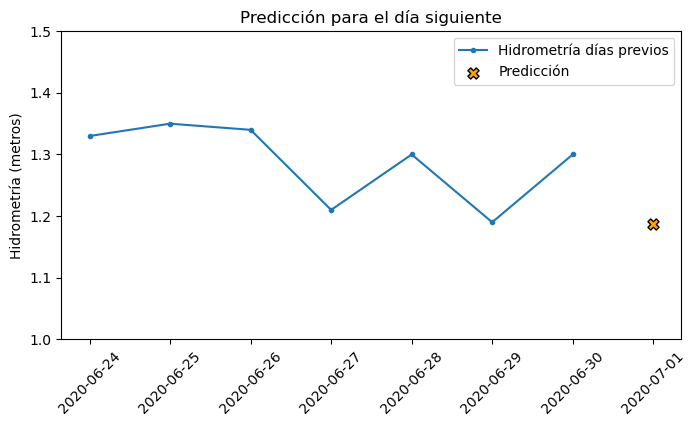

In [85]:
plt.figure(figsize=(8, 4))
plt.plot(df_prediccion.loc['2020-06-24':].index.to_list(), df_prediccion.loc['2020-06-24':,'Hydrometry_Nave_di_Rosano'],
     label='Hidrometría días previos', marker='.')

plt.scatter(pd.to_datetime('2020-07-01'), prediccion, marker='X', edgecolors='k', label='Predicción', c='orange', s=64)
plt.ylabel('Hidrometría (metros)')
plt.title('Predicción para el día siguiente')
plt.ylim(1,1.5)
plt.xticks(rotation = 45)
plt.legend()

plt.show()

## 6.2 Predicción para dentro de dos semanas

_NOTA: Recordemos que, aunque en este caso se realice la predicción para dentro de dos semanas, el procedimiento que se verá a continuación se puede aplicar para otros horizontes temporales más cortos o largos. Basta con obtener las predicciones de una agencia meteorológica para las temperaturas y precipitaciones de los días previos._

Supongamos que quisiésemos conocer la predicción de la hidrometría dos semanas más allá de la fecha hasta la que disponemos datos: es decir, queremos una predicción para el 2020-07-14. 

A diferencia de la predicción para el día siguiente, las predicciones para horizontes temporales más largos presentan una complicación adicional: a priori, no poseemos de todos los datos necesarios para poder hacer la predicción. Nuestro modelo necesita conocer los valores de Temperatura, Precipitaciones e Hidrometría de los 7 días anteriores al día que se quiere hacer la predicción. Se valoran dos enfoques diferentes para resolver este problema:

   - Se puede entrenar la red neuronal para que aprenda a hacer predicciones para dentro de 14 días, en vez de hacerlas para dentro de 1 día. Habría que especificar una ventana diferente a la que se ha utilizado, y rehacer el entrenamiento.
   
A continuación, se indica cómo se generaría una ventana para predecir la hidrometría dentro de 14 días, utilizando un histórico de 7 días de las variables predictoras

In [86]:
ventana_alternativa = WindowGenerator(
    input_width=7,
    label_width=1,
    shift=14,
    label_columns=['Hydrometry_Nave_di_Rosano'])

ventana_alternativa

Índices de los días predictores: [0 1 2 3 4 5 6]
Índices de los días a predecir: [20]
Variables objetivo: ['Hydrometry_Nave_di_Rosano']

Este enfoque presenta un gran inconveniente, y es que, como vimos en el capítulo de análisis exploratorio de datos, las Precipitaciones influyen sobre el nivel del río unos pocos días después de ocurrir, pasados esos días su influencia se disipa. Para predecir cómo serán los niveles del río el día 20, no parece muy importante conocer lo que haya llovido los días 0 a 6, sería mucho más determinante conocer lo que ha llovido los días 17, 18 o 19.

Así que se utilizará un enfoque alternativo, que se considera que se adapta mucho mejor a las peculiaridades de nuestro problema:

   - Mantener el modelo que ya hemos entrenado: predecir para el día siguiente, utilizando los datos de los 7 días anteriores. Reutilizar esta predicción de la Hidrometría del día siguiente, más las predicciones de una agencia meteorológica para Temperaturas y Precipitaciones, para obtener una predicción de la Hidrometría para dentro de dos días. Realizar sucesivas iteraciones hasta obtener la predicción para dentro de 14 días.
   
Este enfoque presenta una gran ventaja, y es que así sí que se están utilizando las precipitaciones de los días inmediatamente anteriores como variables predictoras. Además, para los valores futuros de Precipitaciones y Temperatura, no hace falta utilizar las predicciones de este mismo modelo, el cual no está específicamente diseñado para predecirlas. En su lugar, utilizamos las predicciones de una agencia meteorológica, mucho más adaptadas para predecir correctamente Precipitaciones y Temperatura.

Inicialmente, para poner este enfoque en práctica, se consideró ofrecer la predicción para el 2020-07-14. Ya que, como hemos indicado, es la fecha que coincide con dos semanas después del final de los datos de nuestro dataset. Sin embargo, en esa época del año las precipitaciones son escasas y los niveles del río son estables y fácilmente predecibles. Así que se va a realizar la predicción para una época del año más lluviosa (en concreto, la época en la que se redacta este documento, otoño de 2022).

Suponemos que estamos a fecha de 16 de Noviembre de 2022. La compañía gestora necesita una predicción de la Hidrometría para dentro de 14 días, es decir el 30 de Noviembre de 2022. Para ello, vamos a necesitar los siguientes datos externos:

   - Valores reales de fechas previas: Necesitamos conocer Hidrometría, Precipitaciones y Temperaturas de los 7 días anteriores al momento actual. Es decir, el intervalo del 10 al 16 de Noviembre
   - Valores estimados para Precipitaciones y Temperatura desde el momento actual hasta el día anterior al que queremos predecir. Es decir, el intervalo del 17 al 29 de Noviembre
   
Cargamos estos datos que hemos almacenado en un fichero .csv

_NOTA: Los valores estimados de Precipitaciones y Temperatura (del 2022-11-17 al 2022-11-29) han sido obtenidos de la siguiente página web: https://www.ilmeteo.it/meteo/Firenze. Para los valores de Precipitaciones y Temperatura de fechas previas (2022-11-10 a 2022-11-16), no se disponía de información en esa página web, y no se encontró ninguna otra página web que ofreciese tanto Precipitaciones y Temperatura de fechas previas, como de fechas futuras. Para la Hidrometría en Nave di Rosano se encontró esta web https://www.cfr.toscana.it/monitoraggio/stazioni.php?type=idro, pero hay dos puntos de medición para este lugar, y desconocemos cuál de los dos es el que coincide con el que tenemos en nuestro dataset._

_Así que, para no complicar esta parte en demasía, se decide generar datos dummy para Hidrometría, Temperatura y Precipitaciones de fechas previas. Simplemente se replican los valores que tuvimos en ese mismo intervalo en un año del que sí disponemos datos: del 2019-11-10 a 2019-11-16_. 

In [87]:
# Cargamos el .csv y procesamos la fecha como índice
df_2022 = pd.read_csv('datos_actuales.csv', names=['Date', 'Temperature_Firenze', 'Hydrometry_Nave_di_Rosano', 'Mean_Rainfall'])
df_2022['Date'] = pd.to_datetime(df_2022['Date'], format="%d/%m/%Y")
df_2022 = df_2022.set_index('Date')

# Inspeccionamos
df_2022.head(25)

,Temperature_Firenze,Hydrometry_Nave_di_Rosano,Mean_Rainfall
Date,,,
2022-11-10,9.0,2.30,8.00
2022-11-11,12.0,1.90,19.04
2022-11-12,12.0,1.61,5.28
2022-11-13,10.0,2.06,0.20
2022-11-14,11.0,2.00,34.00
2022-11-15,12.0,2.19,30.88
2022-11-16,11.0,3.47,59.48
2022-11-17,11.0,NaN,25.44
2022-11-18,15.2,NaN,4.10


Generamos la variable Momento del año y normalizamos los datos.

In [88]:
df_2022['Year_sin'] = df.loc['2019-11-10':'2019-11-30', 'Year_sin'].to_list()
df_2022['Year_cos'] = df.loc['2019-11-10':'2019-11-30', 'Year_cos'].to_list()

df_2022 = (df_2022 - train_mean) / train_std

df_2022.head(10)

,Temperature_Firenze,Hydrometry_Nave_di_Rosano,Mean_Rainfall,Year_sin,Year_cos
Date,,,,,
2022-11-10,-1.008752,1.349150,0.706064,-1.101132,0.886970
2022-11-11,-0.603538,0.680846,2.219075,-1.085704,0.905777
2022-11-12,-0.603538,0.196326,0.333293,-1.069955,0.924316
2022-11-13,-0.873681,0.948168,-0.362912,-1.053890,0.942581
2022-11-14,-0.738609,0.847922,4.269315,-1.037512,0.960567
2022-11-15,-0.603538,1.165367,3.841725,-1.020828,0.978269
2022-11-16,-0.738609,3.303939,7.761302,-1.003841,0.995681
2022-11-17,-0.738609,NaN,3.096183,-0.986558,1.012799
2022-11-18,-0.171310,NaN,0.171576,-0.968982,1.029617


De forma iterativa, en primer lugar obtenemos la predicción de la Hidrometría para 2022-11-17, y así sucesivamente hasta llegar a la fecha objetivo: 2022-11-30.

In [89]:
from pandas.tseries.offsets import DateOffset

In [90]:
fecha_actual = pd.to_datetime('2022-11-16')

for date in pd.date_range(start=fecha_actual, end=fecha_actual+DateOffset(days=13) , freq='D'):
    
    # Obtenemos el conjunto de datos que se usará para predecir un día determinado (los 7 días anteriores)
    df_prediccion = df_2022.loc[date - DateOffset(days=6): date + DateOffset(days=1)]
    
    # Pasamos el conjunto de datos al modelo para que nos devuelva la predicción
    prediccion = float(lstm_model.predict(ventana_prediccion.make_dataset(df_prediccion)))
    
    # Insertamos esa predicción en el dataframe, será variable predictora en la siguiente iteración
    df_2022.loc[date + DateOffset(days=1), 'Hydrometry_Nave_di_Rosano'] =  prediccion
    
    # Se reinicia el bucle para la fecha siguiente

1/1 [==============================] - 0s 73ms/step


Devolvemos los valores a su escala real.

In [91]:
df_2022 = df_2022 * train_std + train_mean
df_2022.tail()

,Temperature_Firenze,Hydrometry_Nave_di_Rosano,Mean_Rainfall,Year_sin,Year_cos
Date,,,,,
2022-11-26,11.9,2.296963,2.0,-0.578783,0.815482
2022-11-27,9.8,2.200532,0.0,-0.564670,0.825317
2022-11-28,5.6,2.044715,0.0,-0.550389,0.834908
2022-11-29,8.9,1.923158,0.5,-0.535946,0.844253
2022-11-30,8.0,1.889409,0.0,-0.521343,0.853347


Visualizamos las predicciones del modelo.

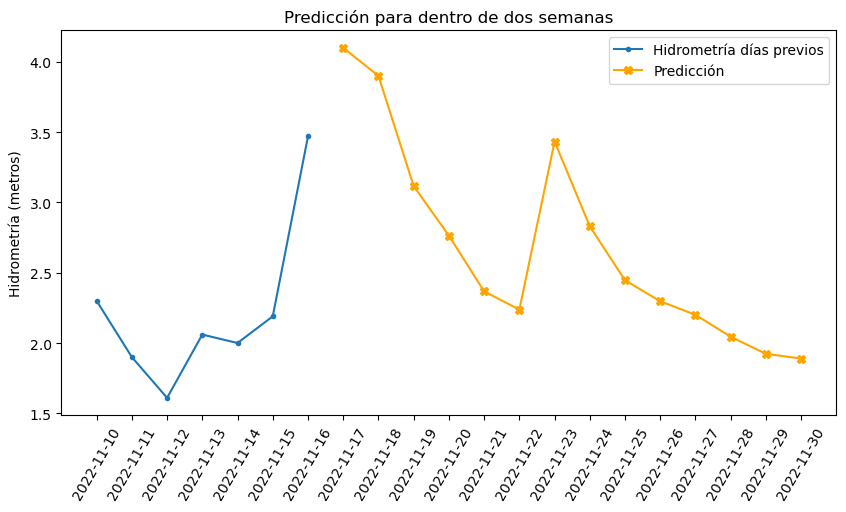

In [92]:
fecha_inicial = fecha_actual - DateOffset(days=6)
inicio_predicciones = fecha_actual + DateOffset(days=1)
fin_predicciones = fecha_actual + DateOffset(days=14)

plt.figure(figsize=(10, 5))

plt.plot(pd.date_range(start=fecha_inicial, end=fecha_actual , freq='D'), 
             df_2022.loc[fecha_inicial:fecha_actual:,'Hydrometry_Nave_di_Rosano'],
             label='Hidrometría días previos', marker='.')

plt.plot(pd.date_range(start=inicio_predicciones, end=fin_predicciones, freq='D'), 
            df_2022.loc[inicio_predicciones:fin_predicciones,'Hydrometry_Nave_di_Rosano'], 
            label='Predicción', marker='X', c='orange')

plt.ylabel('Hidrometría (metros)')
plt.title('Predicción para dentro de dos semanas')
plt.xticks(pd.date_range(start=fecha_inicial 
                         , end=fin_predicciones, freq='D'), rotation = 60)
plt.legend()

plt.show()

Visualizamos valores de Hidrometría conjuntamente con las Predicciones (ambas variables reales hasta el día 16, predichas a partir de entonces).

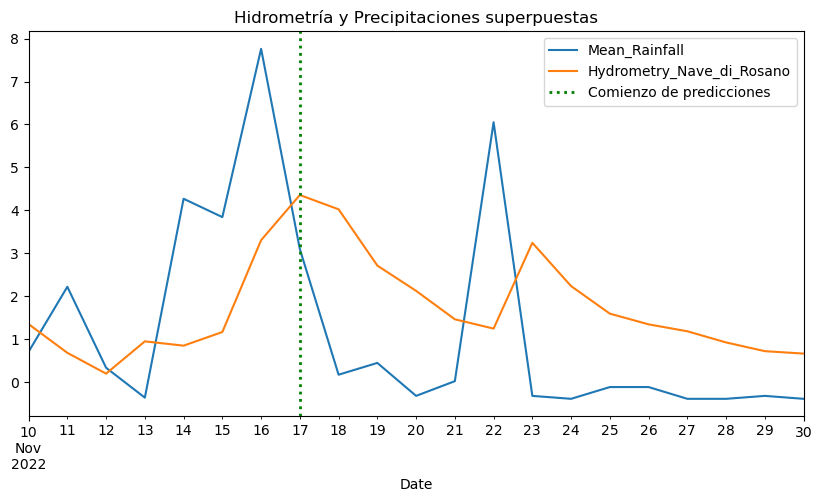

In [93]:
((df_2022 - train_mean) / train_std)[['Mean_Rainfall', 'Hydrometry_Nave_di_Rosano' ]].plot(figsize=(10, 5))

plt.title('Hidrometría y Precipitaciones superpuestas')
plt.axvline(x=pd.to_datetime('2022-11-17'), color='green', ls=':', lw=2, label='Comienzo de predicciones')
plt.legend()

plt.show()

Vemos como, tanto en el intervalo de datos reales como de datos predichos, la Hidrometría sigue ese comportamiento que hemos venido observando desde el capítulo de análisis exploratorio: está muy influenciada por las Precipitaciones, de varios días anteriores.